In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.saving import register_keras_serializable

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')
dataset_csv_path = os.path.join(data_folder, 'HAM10000_metadata.csv')

dataset_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'Augmented_images']
train_csv_path = os.path.join(data_folder, 'train.csv')
val_csv_path = os.path.join(data_folder, 'val.csv')

test_folder = ["Test_images"]
test_csv_path = os.path.join(data_folder, 'test.csv')

models_folder = os.path.join(root_folder, 'models')
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

In [3]:
df = pd.read_csv(dataset_csv_path)
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])

categories = list(label_encoder.classes_)
encodings = label_encoder.transform(label_encoder.classes_)

label_mapping = dict(zip(categories, encodings))
label_mapping

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [4]:
batch_size = 32  
init_lr = 1e-3
epochs = 100
init_lr_ft = 1e-5
batch_size_ft = 8

### Load data

In [5]:
def load_dataframe(csv_path, data_folder, folders, label_encoder):
    data_df = pd.read_csv(csv_path)
    
    jpg_files = []
    for folder in folders:
        jpg_files.extend(glob(os.path.join(data_folder, folder, '*.jpg')))

    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                        for x in jpg_files}

    data_df['path'] = data_df['image_id'].map(imageid_path_dict.get)
    data_df['class'] = label_encoder.transform(data_df['dx'])
    
    return data_df

In [6]:
def load_data(csv_path, data_folder, folders, label_encoder, image_size, keep_aspect=True, fill_value=0):
    df = load_dataframe(csv_path, data_folder, folders, label_encoder)

    data = []
    for _, row in df.iterrows():
        img_path = row['path']
        img_class = row['class']

        if os.path.isfile(img_path):
            data.append((img_path, img_class))

    x = np.zeros((len(data), image_size, image_size, 3), np.uint8)
    y = np.zeros((len(data), 1), np.uint8)

    for i in range(len(data)):
        file, c = data[i]
        y[i] = c
        img = cv2.imread(file)
        if img is None:
            print(file, c)
        if keep_aspect:
            cy = img.shape[0]
            cx = img.shape[1]
            if cx > cy:
                d = cx - cy
                img = cv2.copyMakeBorder(img, top=d//2, bottom=d-d//2, left=0, right=0,
                                        borderType=cv2.BORDER_CONSTANT, value=fill_value)
            else:
                d = cy - cx
                img = cv2.copyMakeBorder(img, top=0, bottom=0, left=d//2, right=d-d//2,
                                        borderType=cv2.BORDER_CONSTANT, value=fill_value)
        img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        x[i] = img

    rand_train_idx = np.random.RandomState(seed=0).permutation(len(data))

    x = x[rand_train_idx]
    y = y[rand_train_idx]

    return data, x, y

### Create and train models

In [7]:
vgg16_img_size = 224
vgg16_input_shape = (224, 224, 3)
inceptionv3_img_size = 299
inceptionv3_input_shape = (299, 299, 3)
resnet_img_size = 224
resnet_input_shape = (224, 224, 3)
mobilenet_img_size = 224
mobilenet_input_shape = (224, 224, 3)
efficientnet_img_size = 260
efficientnet_input_shape = (260, 260, 3)

In [8]:
@register_keras_serializable(package='Custom', name='preprocess_input_vgg16')
def preprocess_input_vgg16(*args, **kwargs):
    return tf.keras.applications.vgg16.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_inceptionv3')
def preprocess_input_inceptionv3(*args, **kwargs):
    return tf.keras.applications.inception_v3.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_resnet')
def preprocess_input_resnet(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_mobilenet')
def preprocess_input_mobilenet(*args, **kwargs):
    return tf.keras.applications.mobilenet_v2.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_efficientnet')
def preprocess_input_efficientnet(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)


def create_model(backbone_name, input_shape, classes, trainable_encoder=False):
    x = tf.keras.layers.Input(shape=input_shape, name='input')

    if backbone_name == "vgg16":
        y = tf.keras.layers.Lambda(preprocess_input_vgg16, name='adjust_input')(x)
        backbone = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "inceptionv3":
        y = tf.keras.layers.Lambda(preprocess_input_inceptionv3, name='adjust_input')(x)
        backbone = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "resnet":
        y = tf.keras.layers.Lambda(preprocess_input_resnet, name='adjust_input')(x)
        backbone = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "mobilenet":
        y = tf.keras.layers.Lambda(preprocess_input_mobilenet, name='adjust_input')(x)
        backbone = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "efficientnet":
        y = tf.keras.layers.Lambda(preprocess_input_efficientnet, output_shape=input_shape, name='adjust_input')(x)
        backbone = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)

    if not trainable_encoder:
        for layer in backbone.layers:
            layer.trainable = False

    y = backbone.output

    y = tf.keras.layers.Dropout(rate=0.5)(y)
    y = tf.keras.layers.Dense(classes, activation='softmax', name='output')(y)

    model = tf.keras.models.Model(inputs=x, outputs=y)

    return model

In [9]:
def save_history(hist, folder):
    plt.figure(figsize=(20, 8))

    epochs = range(1, len(hist.history['loss']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.history['loss'], 'r', label='Train loss')
    plt.plot(epochs, hist.history['val_loss'], 'g', label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.history['sparse_categorical_accuracy'], 'r', label='Train accuracy')
    plt.plot(epochs, hist.history['val_sparse_categorical_accuracy'], 'g', label='Val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(folder, 'history.png'))
    plt.show()

In [10]:
def train_model(model_name, models_folder, model, x_train, y_train, x_val, y_val, batch_size, epochs, class_weights=None):
    res_folder = os.path.join(models_folder, model_name)
    if not os.path.exists(res_folder):
        os.mkdir(res_folder)

    path = os.path.join(res_folder, 'trained_model.keras')

    save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_sparse_categorical_accuracy', mode='max',
                                                    verbose=1, save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max',
                                                    patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', mode='max',
                                                    factor=0.1, patience=3, verbose=1)
    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(res_folder, 'training.csv'))

    hist = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[save_model, early_stopping, reduce_lr, csv_logger],
                    class_weight=class_weights,
                    verbose=1)

    save_history(hist, res_folder)
    
    return model

In [ ]:
def evaluate_model(model, batch_size, x_val, y_val, x_test, y_test, categories, encodings):
    res_val = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
    res_test = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
    print(f"Val loss: {res_val[0]}, Val accuracy: {res_val[1]}")
    print(f"Test loss: {res_test[0]}, Test accuracy: {res_test[1]}")

    y_pred_prob = model.predict(x_test, batch_size=batch_size)
    y_pred = np.argmax(y_pred_prob, axis=1)

    conf_matrix = confusion_matrix(y_test, y_pred, labels=encodings)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, cmap="Reds", linecolor='black', linewidth=1, annot=True, fmt='')
    plt.show()

    if len(categories) == 2:
        classes = categories
    else:
        dx_dict = {
            'nv': 'Melanocytic nevus',
            'mel': 'Melanoma',
            'bkl': 'Benign keratosis',
            'bcc': 'Basal cell carcinoma',
            'akiec': 'Actinic keratosis',
            'vasc': 'Vascular lesion',
            'df': 'Dermatofibroma'
        }
        classes = [dx_dict[key] for key in categories]

    label_frac_error = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    plt.figure(figsize=(15, 4))
    plt.bar(classes, label_frac_error)
    plt.xlabel('True label')
    plt.ylabel('Fraction classified incorrectly')
    plt.show()

    report = classification_report(y_test, y_pred, target_names=classes)
    print("Classification Report:")
    print(report)

## Initial results

### VGG16

In [13]:
vgg16_train_data, vgg16_x_train, vgg16_y_train = load_data(train_csv_path, data_folder, dataset_folders, label_encoder, vgg16_img_size)
vgg16_val_data, vgg16_x_val, vgg16_y_val = load_data(val_csv_path, data_folder, dataset_folders, label_encoder, vgg16_img_size)
vgg16_test_data, vgg16_x_test, vgg16_y_test = load_data(test_csv_path, data_folder, test_folder, label_encoder, vgg16_img_size)
print(vgg16_x_train.shape, vgg16_y_train.shape, vgg16_x_val.shape, vgg16_y_val.shape, vgg16_x_test.shape, vgg16_y_test.shape)

(7840, 224, 224, 3) (7840, 1) (1960, 224, 224, 3) (1960, 1) (1512, 224, 224, 3) (1512, 1)


In [ ]:
vgg16_model = create_model("vgg16", vgg16_input_shape, classes=len(categories), trainable_encoder=False)

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

vgg16_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adjust_input (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 3.8368 - sparse_categorical_accuracy: 0.2122
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.50051, saving model to .\models\VGG16-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 1863s 8s/step - loss: 3.8328 - sparse_categorical_accuracy: 0.2125 - val_loss: 1.3363 - val_sparse_categorical_accuracy: 0.5005 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.7654 - sparse_categorical_accuracy: 0.4038
Epoch 2: val_sparse_categorical_accuracy improved from 0.50051 to 0.57296, saving model to .\models\VGG16-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 1831s 7s/step - loss: 1.7650 - sparse_categorical_accuracy: 0.4039 - val_loss: 1.1724 - val_sparse_categorical_accuracy: 0.5730 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.4227 - sparse_categorical_accuracy: 0.4822
Epoch 3: val_sparse_categorical_accuracy improved from 0

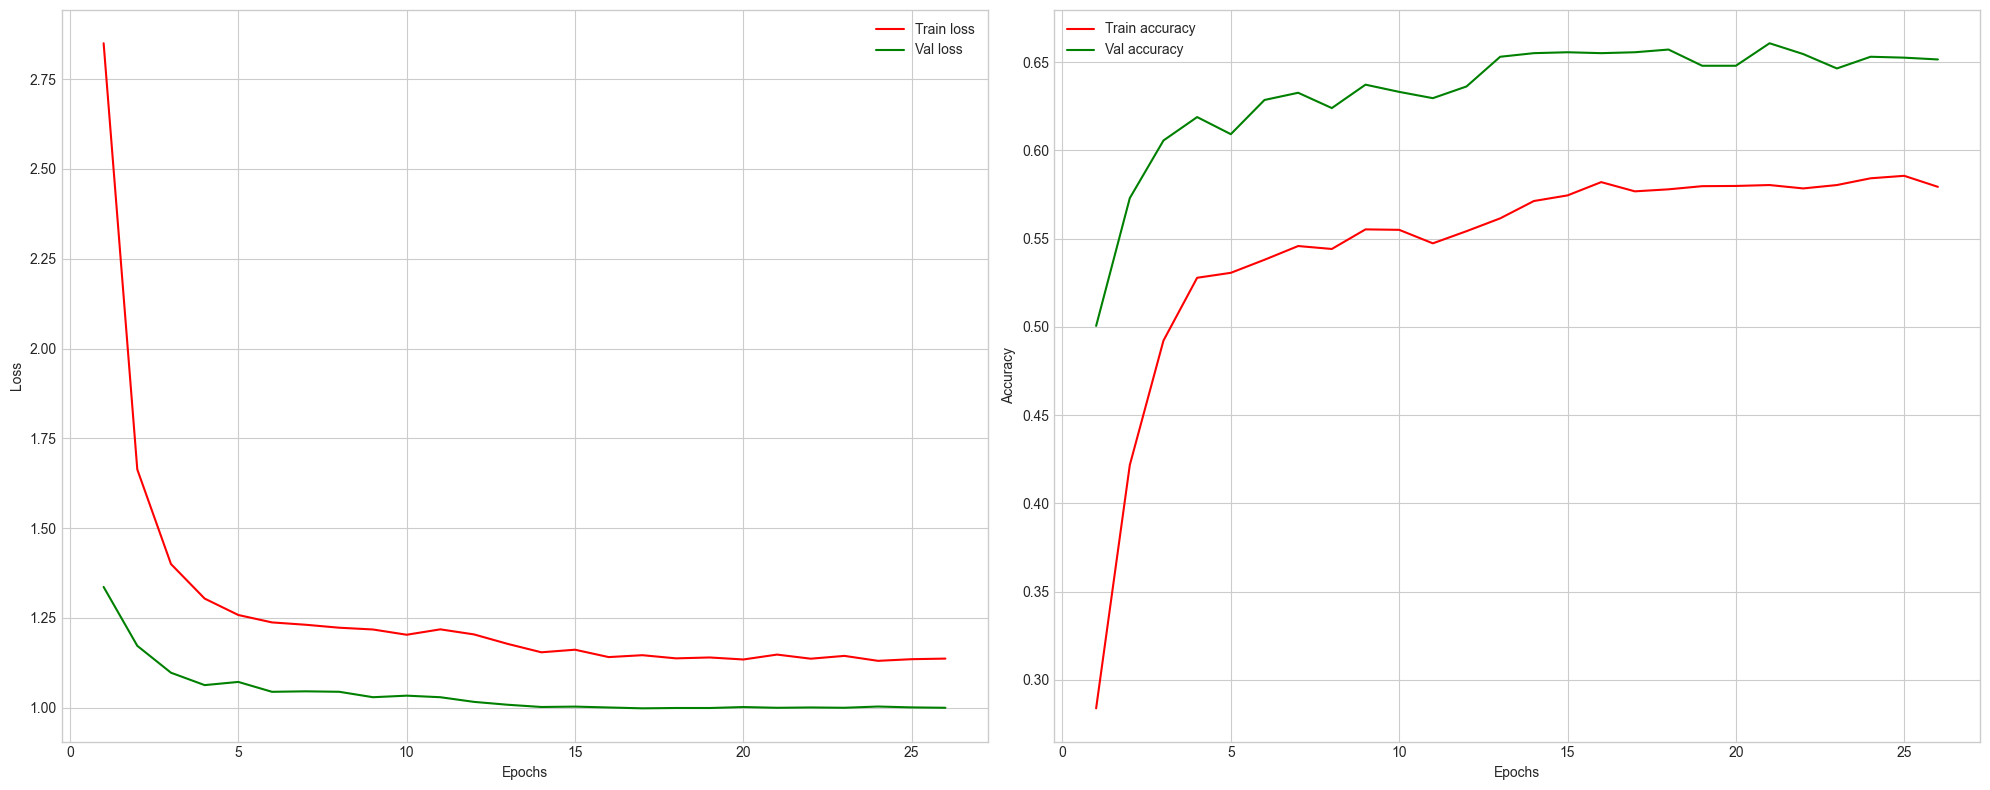

In [ ]:
vgg16_model = train_model("VGG16-balanced", models_folder, vgg16_model, vgg16_x_train, vgg16_y_train, vgg16_x_val, vgg16_y_val, batch_size, epochs)

62/62 ━━━━━━━━━━━━━━━━━━━━ 346s 6s/step - loss: 0.9851 - sparse_categorical_accuracy: 0.6683
48/48 ━━━━━━━━━━━━━━━━━━━━ 280s 6s/step - loss: 1.1668 - sparse_categorical_accuracy: 0.6237
Val loss: 0.9998823404312134, Val accuracy: 0.6607142686843872
Test loss: 1.1345869302749634, Test accuracy: 0.6289682388305664
48/48 ━━━━━━━━━━━━━━━━━━━━ 287s 6s/step


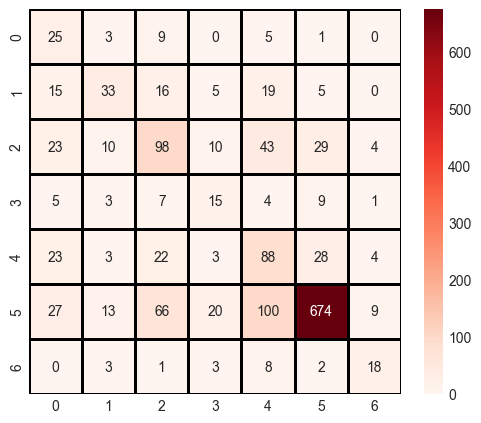

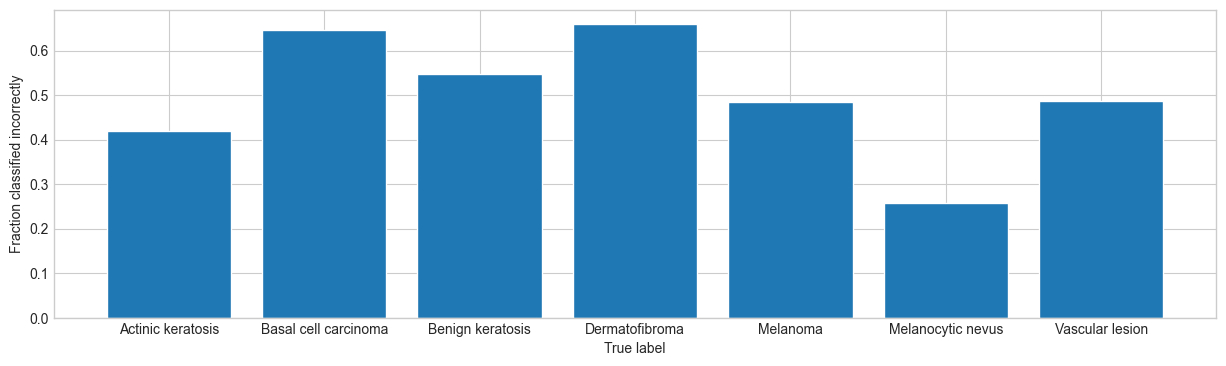

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.21      0.58      0.31        43
Basal cell carcinoma       0.49      0.35      0.41        93
    Benign keratosis       0.45      0.45      0.45       217
      Dermatofibroma       0.27      0.34      0.30        44
            Melanoma       0.33      0.51      0.40       171
   Melanocytic nevus       0.90      0.74      0.81       909
     Vascular lesion       0.50      0.51      0.51        35

            accuracy                           0.63      1512
           macro avg       0.45      0.50      0.46      1512
        weighted avg       0.70      0.63      0.65      1512



In [ ]:
evaluate_model(vgg16_model, batch_size, vgg16_x_val, vgg16_y_val, vgg16_x_test, vgg16_y_test, categories, encodings)

### InceptionV3

In [ ]:
inceptionv3_train_data, inceptionv3_x_train, inceptionv3_y_train = load_data(train_csv_path, data_folder, dataset_folders, label_encoder, inceptionv3_img_size)
inceptionv3_val_data, inceptionv3_x_val, inceptionv3_y_val = load_data(val_csv_path, data_folder, dataset_folders, label_encoder, inceptionv3_img_size)
inceptionv3_test_data, inceptionv3_x_test, inceptionv3_y_test = load_data(test_csv_path, data_folder, test_folder, label_encoder, inceptionv3_img_size)
print(inceptionv3_x_train.shape, inceptionv3_y_train.shape, inceptionv3_x_val.shape, inceptionv3_y_val.shape, inceptionv3_x_test.shape, inceptionv3_y_test.shape)

(7840, 299, 299, 3) (7840, 1) (1960, 299, 299, 3) (1960, 1) (1512, 299, 299, 3) (1512, 1)


In [ ]:
inceptionv3_model = create_model("inceptionv3", inceptionv3_input_shape, classes=len(categories), trainable_encoder=False)

inceptionv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
inceptionv3_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 299, 299,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 299, 299,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]  

 Total params: 21,817,127 (83.23 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.8297 - sparse_categorical_accuracy: 0.3081
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56633, saving model to .\models\InceptionV3-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - loss: 1.8287 - sparse_categorical_accuracy: 0.3085 - val_loss: 1.1805 - val_sparse_categorical_accuracy: 0.5663 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.2599 - sparse_categorical_accuracy: 0.5307
Epoch 2: val_sparse_categorical_accuracy improved from 0.56633 to 0.61122, saving model to .\models\InceptionV3-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - loss: 1.2599 - sparse_categorical_accuracy: 0.5308 - val_loss: 1.0551 - val_sparse_categorical_accuracy: 0.6112 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.1539 - sparse_categorical_accuracy: 0.5709
Epoch 3: val_sparse_categorical_accuracy impro

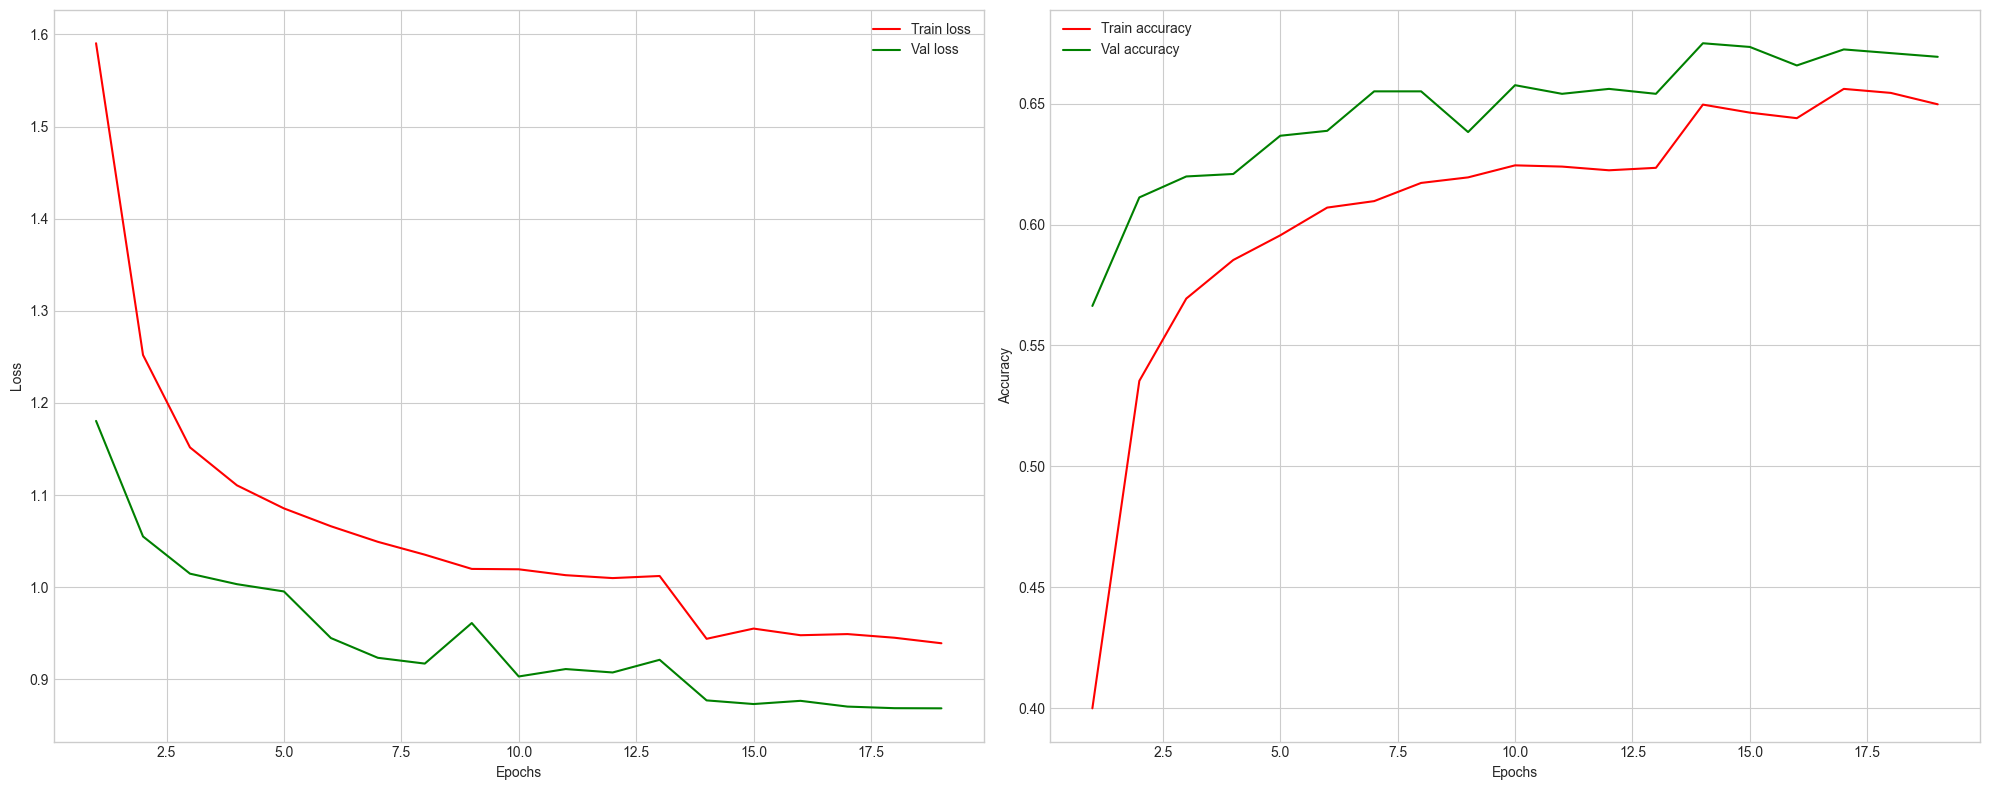

In [ ]:
inceptionv3_model = train_model("InceptionV3-balanced", models_folder, inceptionv3_model, inceptionv3_x_train, inceptionv3_y_train, inceptionv3_x_val, inceptionv3_y_val, batch_size, epochs)

62/62 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - loss: 0.8759 - sparse_categorical_accuracy: 0.6659
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - loss: 1.1087 - sparse_categorical_accuracy: 0.6005
Val loss: 0.8771293759346008, Val accuracy: 0.675000011920929
Test loss: 1.0811114311218262, Test accuracy: 0.6044973731040955
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step


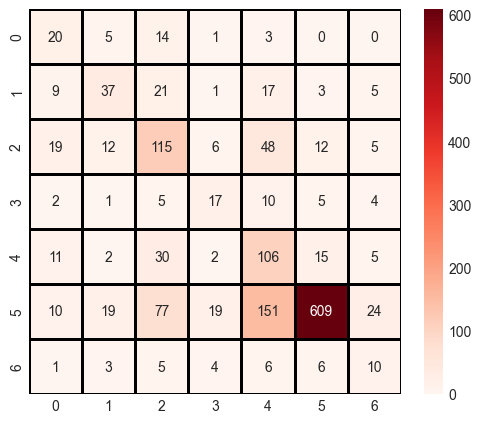

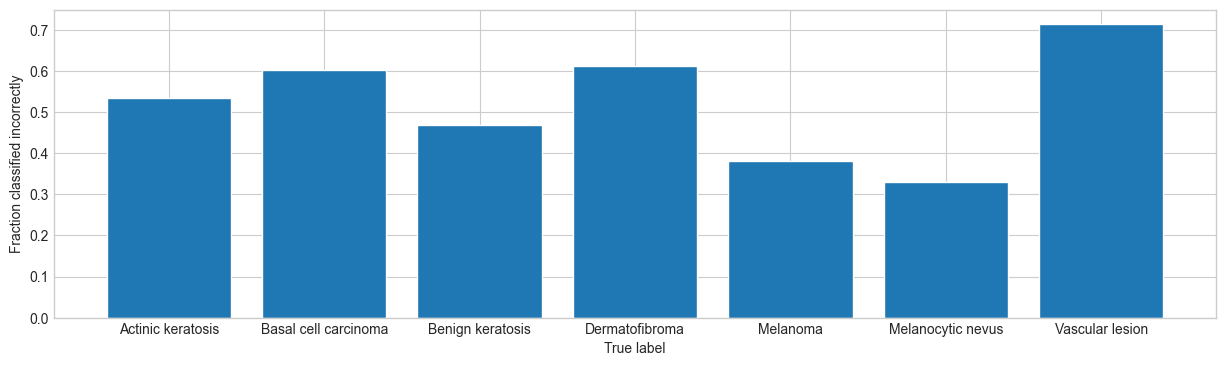

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.28      0.47      0.35        43
Basal cell carcinoma       0.47      0.40      0.43        93
    Benign keratosis       0.43      0.53      0.48       217
      Dermatofibroma       0.34      0.39      0.36        44
            Melanoma       0.31      0.62      0.41       171
   Melanocytic nevus       0.94      0.67      0.78       909
     Vascular lesion       0.19      0.29      0.23        35

            accuracy                           0.60      1512
           macro avg       0.42      0.48      0.43      1512
        weighted avg       0.71      0.60      0.64      1512



In [ ]:
evaluate_model(inceptionv3_model, batch_size, inceptionv3_x_val, inceptionv3_y_val, inceptionv3_x_test, inceptionv3_y_test, categories, encodings)

### ResNet

In [ ]:
resnet_train_data, resnet_x_train, resnet_y_train = load_data(train_csv_path, data_folder, dataset_folders, label_encoder, resnet_img_size)
resnet_val_data, resnet_x_val, resnet_y_val = load_data(val_csv_path, data_folder, dataset_folders, label_encoder, resnet_img_size)
resnet_test_data, resnet_x_test, resnet_y_test = load_data(test_csv_path, data_folder, test_folder, label_encoder, resnet_img_size)
print(resnet_x_train.shape, resnet_y_train.shape, resnet_x_val.shape, resnet_y_val.shape, resnet_x_test.shape, resnet_y_test.shape)

(7840, 224, 224, 3) (7840, 1) (1960, 224, 224, 3) (1960, 1) (1512, 224, 224, 3) (1512, 1)


In [14]:
resnet_model = create_model("resnet", resnet_input_shape, classes=len(categories), trainable_encoder=False)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ adjust_input[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9177 - sparse_categorical_accuracy: 0.3092
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.59235, saving model to .\models\ResNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - loss: 1.9165 - sparse_categorical_accuracy: 0.3096 - val_loss: 1.1439 - val_sparse_categorical_accuracy: 0.5923 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2657 - sparse_categorical_accuracy: 0.5307
Epoch 2: val_sparse_categorical_accuracy improved from 0.59235 to 0.62296, saving model to .\models\ResNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - loss: 1.2655 - sparse_categorical_accuracy: 0.5308 - val_loss: 1.0273 - val_sparse_categorical_accuracy: 0.6230 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1282 - sparse_categorical_accuracy: 0.5856
Epoch 3: val_sparse_categorical_accuracy improved from 0

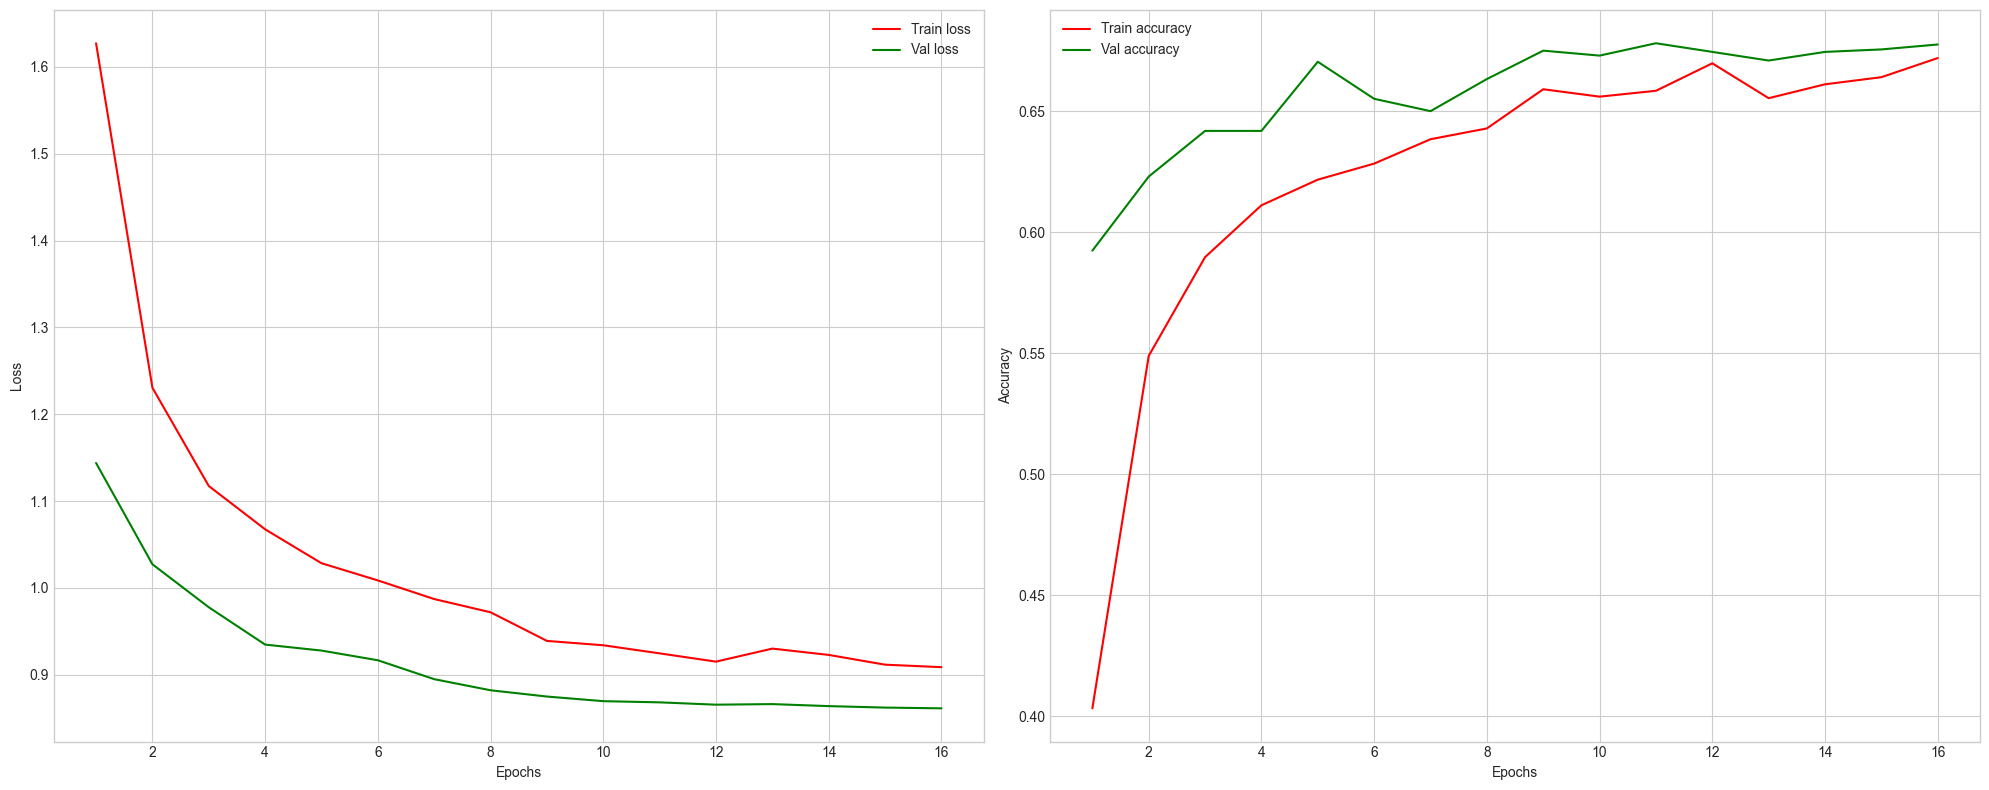

In [ ]:
resnet_model = train_model("ResNet-balanced", models_folder, resnet_model, resnet_x_train, resnet_y_train, resnet_x_val, resnet_y_val, batch_size, epochs)

62/62 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 0.8682 - sparse_categorical_accuracy: 0.6837
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 1.0481 - sparse_categorical_accuracy: 0.6295
Val loss: 0.8683017492294312, Val accuracy: 0.6780612468719482
Test loss: 1.0235872268676758, Test accuracy: 0.636904776096344
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step


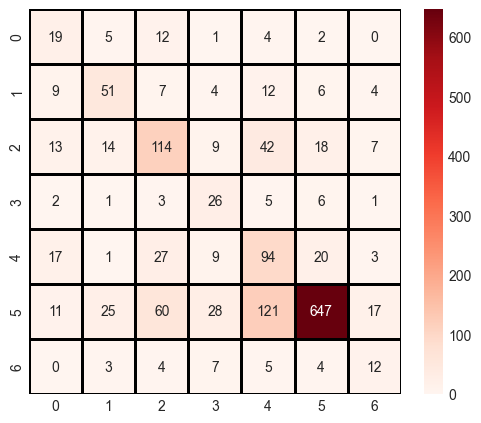

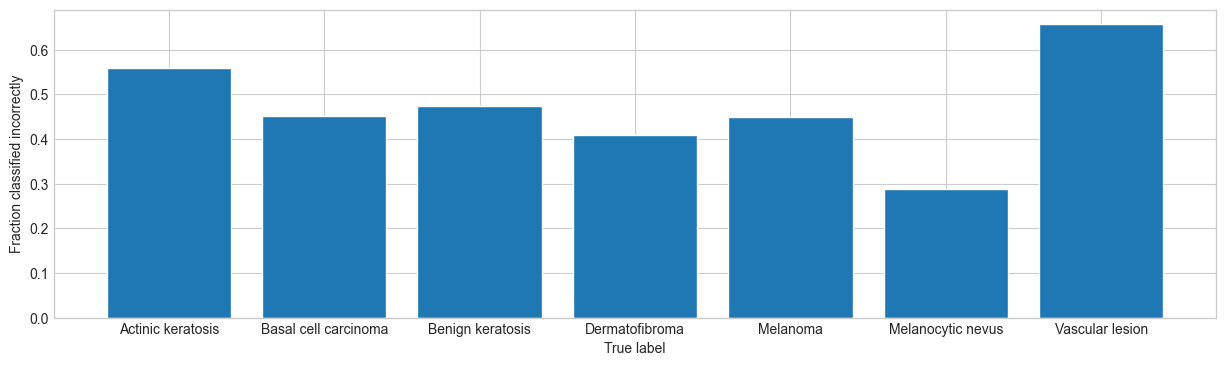

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.27      0.44      0.33        43
Basal cell carcinoma       0.51      0.55      0.53        93
    Benign keratosis       0.50      0.53      0.51       217
      Dermatofibroma       0.31      0.59      0.41        44
            Melanoma       0.33      0.55      0.41       171
   Melanocytic nevus       0.92      0.71      0.80       909
     Vascular lesion       0.27      0.34      0.30        35

            accuracy                           0.64      1512
           macro avg       0.44      0.53      0.47      1512
        weighted avg       0.72      0.64      0.66      1512



In [ ]:
evaluate_model(resnet_model, batch_size, resnet_x_val, resnet_y_val, resnet_x_test, resnet_y_test, categories, encodings)

### MobileNet

In [ ]:
mobilenet_train_data, mobilenet_x_train, mobilenet_y_train = load_data(train_csv_path, data_folder, dataset_folders, label_encoder, mobilenet_img_size)
mobilenet_val_data, mobilenet_x_val, mobilenet_y_val = load_data(val_csv_path, data_folder, dataset_folders, label_encoder, mobilenet_img_size)
mobilenet_test_data, mobilenet_x_test, mobilenet_y_test = load_data(test_csv_path, data_folder, test_folder, label_encoder, mobilenet_img_size)
print(mobilenet_x_train.shape, mobilenet_y_train.shape, mobilenet_x_val.shape, mobilenet_y_val.shape, mobilenet_x_test.shape, mobilenet_y_test.shape)

(7840, 224, 224, 3) (7840, 1) (1960, 224, 224, 3) (1960, 1) (1512, 224, 224, 3) (1512, 1)


In [ ]:
mobilenet_model = create_model("mobilenet", mobilenet_input_shape, classes=len(categories), trainable_encoder=False)

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 1.9894 - sparse_categorical_accuracy: 0.2964
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.59388, saving model to .\models\MobileNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 143s 543ms/step - loss: 1.9881 - sparse_categorical_accuracy: 0.2968 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.5939 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 1.3078 - sparse_categorical_accuracy: 0.5251
Epoch 2: val_sparse_categorical_accuracy improved from 0.59388 to 0.64031, saving model to .\models\MobileNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 136s 556ms/step - loss: 1.3075 - sparse_categorical_accuracy: 0.5251 - val_loss: 0.9727 - val_sparse_categorical_accuracy: 0.6403 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 1.1473 - sparse_categorical_accuracy: 0.5764
Epoch 3: val_sparse_categorical_acc

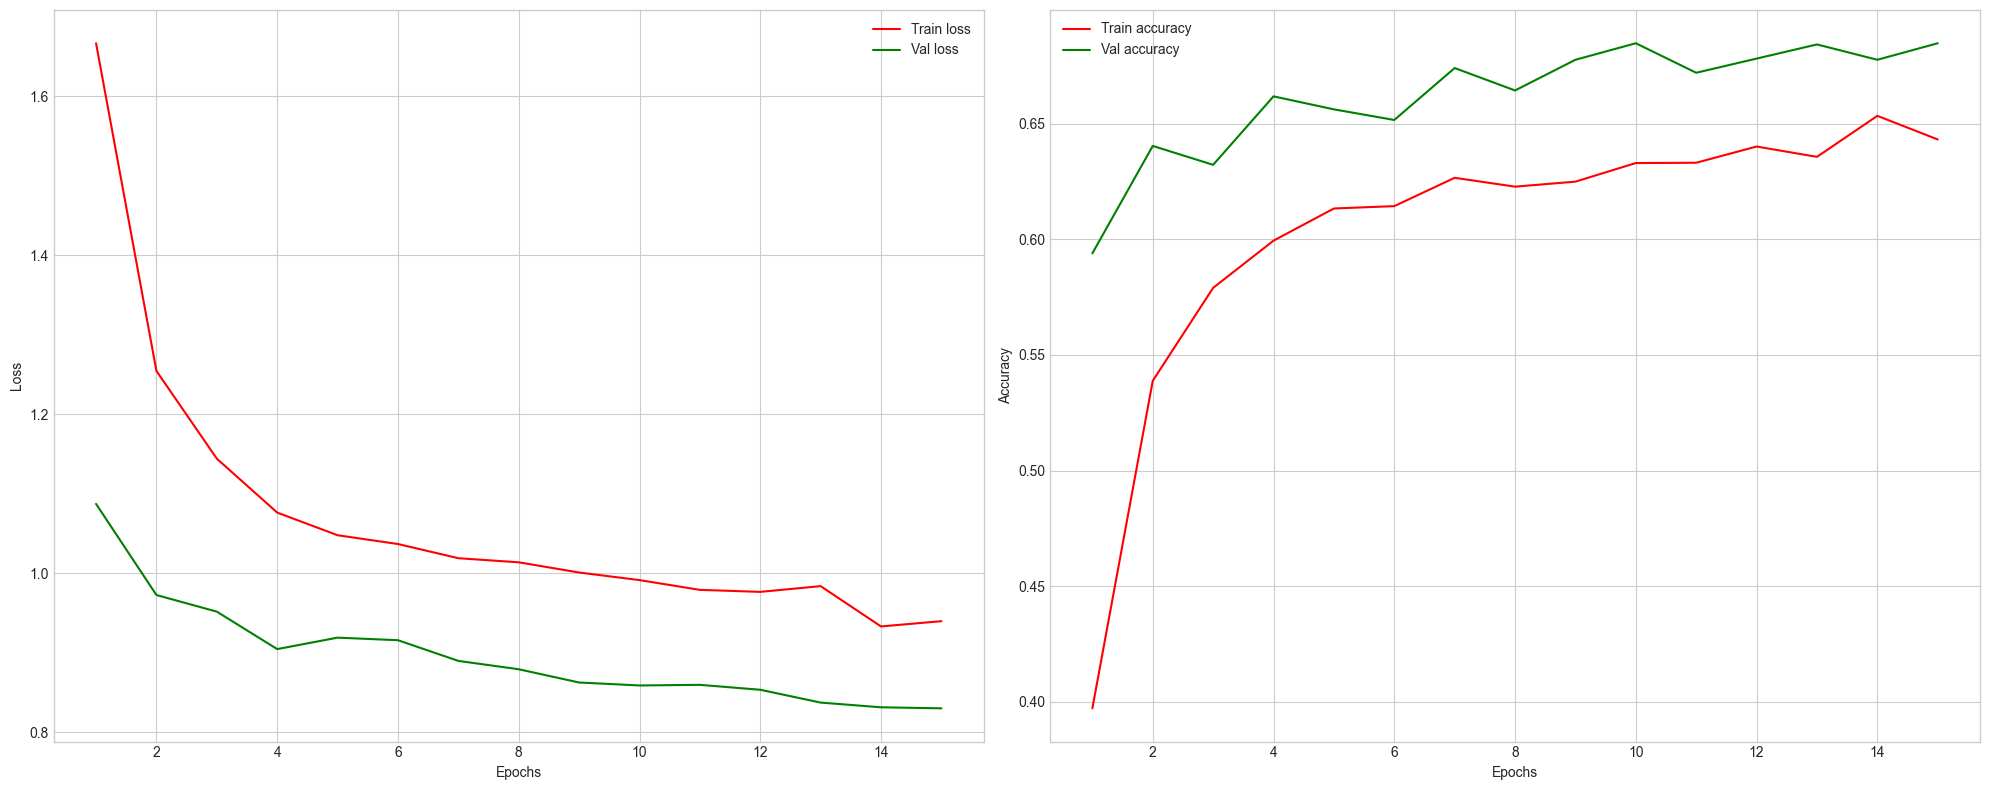

In [ ]:
mobilenet_model = train_model("MobileNet-balanced", models_folder, mobilenet_model, mobilenet_x_train, mobilenet_y_train, mobilenet_x_val, mobilenet_y_val, batch_size, epochs)

62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - loss: 0.8709 - sparse_categorical_accuracy: 0.6789
48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 403ms/step - loss: 1.0352 - sparse_categorical_accuracy: 0.6426
Val loss: 0.8589504957199097, Val accuracy: 0.6846938729286194
Test loss: 1.0066783428192139, Test accuracy: 0.6375661492347717
48/48 ━━━━━━━━━━━━━━━━━━━━ 22s 426ms/step


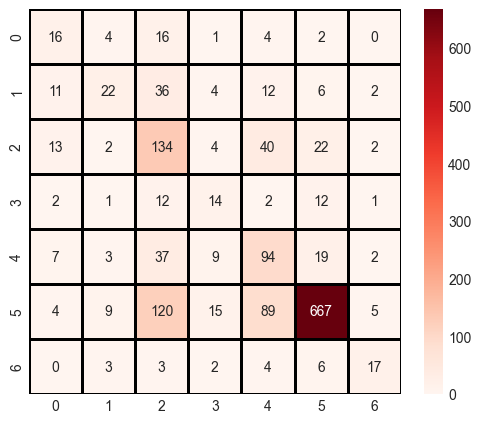

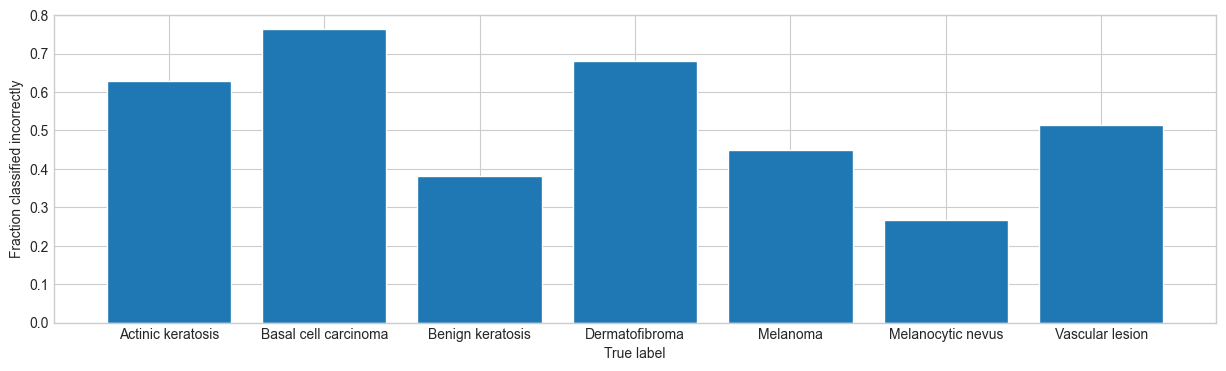

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.30      0.37      0.33        43
Basal cell carcinoma       0.50      0.24      0.32        93
    Benign keratosis       0.37      0.62      0.47       217
      Dermatofibroma       0.29      0.32      0.30        44
            Melanoma       0.38      0.55      0.45       171
   Melanocytic nevus       0.91      0.73      0.81       909
     Vascular lesion       0.59      0.49      0.53        35

            accuracy                           0.64      1512
           macro avg       0.48      0.47      0.46      1512
        weighted avg       0.70      0.64      0.66      1512



In [ ]:
evaluate_model(mobilenet_model, batch_size, mobilenet_x_val, mobilenet_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)

### EfficientNet

In [ ]:
efficientnet_train_data, efficientnet_x_train, efficientnet_y_train = load_data(train_csv_path, data_folder, dataset_folders, label_encoder, efficientnet_img_size)
efficientnet_val_data, efficientnet_x_val, efficientnet_y_val = load_data(val_csv_path, data_folder, dataset_folders, label_encoder, efficientnet_img_size)
efficientnet_test_data, efficientnet_x_test, efficientnet_y_test = load_data(test_csv_path, data_folder, test_folder, label_encoder, efficientnet_img_size)
print(efficientnet_x_train.shape, efficientnet_y_train.shape, efficientnet_x_val.shape, efficientnet_y_val.shape, efficientnet_x_test.shape, efficientnet_y_test.shape)

(7840, 260, 260, 3) (7840, 1) (1960, 260, 260, 3) (1960, 1) (1512, 260, 260, 3) (1512, 1)


In [16]:
efficientnet_model = create_model("efficientnet", efficientnet_input_shape, classes=len(categories), trainable_encoder=False)

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

efficientnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 260, 260,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 260, 260,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ adjust_input[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati

 Total params: 7,778,432 (29.67 MB)

 Trainable params: 9,863 (38.53 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

Epoch 1/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6388 - sparse_categorical_accuracy: 0.3633
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61327, saving model to .\models\EfficientNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - loss: 1.6380 - sparse_categorical_accuracy: 0.3637 - val_loss: 1.1283 - val_sparse_categorical_accuracy: 0.6133 - learning_rate: 0.0010
Epoch 2/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.2047 - sparse_categorical_accuracy: 0.5567
Epoch 2: val_sparse_categorical_accuracy improved from 0.61327 to 0.64082, saving model to .\models\EfficientNet-balanced\trained_model.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - loss: 1.2046 - sparse_categorical_accuracy: 0.5567 - val_loss: 1.0112 - val_sparse_categorical_accuracy: 0.6408 - learning_rate: 0.0010
Epoch 3/100
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.1056 - sparse_categorical_accuracy: 0.5905
Epoch 3: val_sparse_categorical_accuracy imp

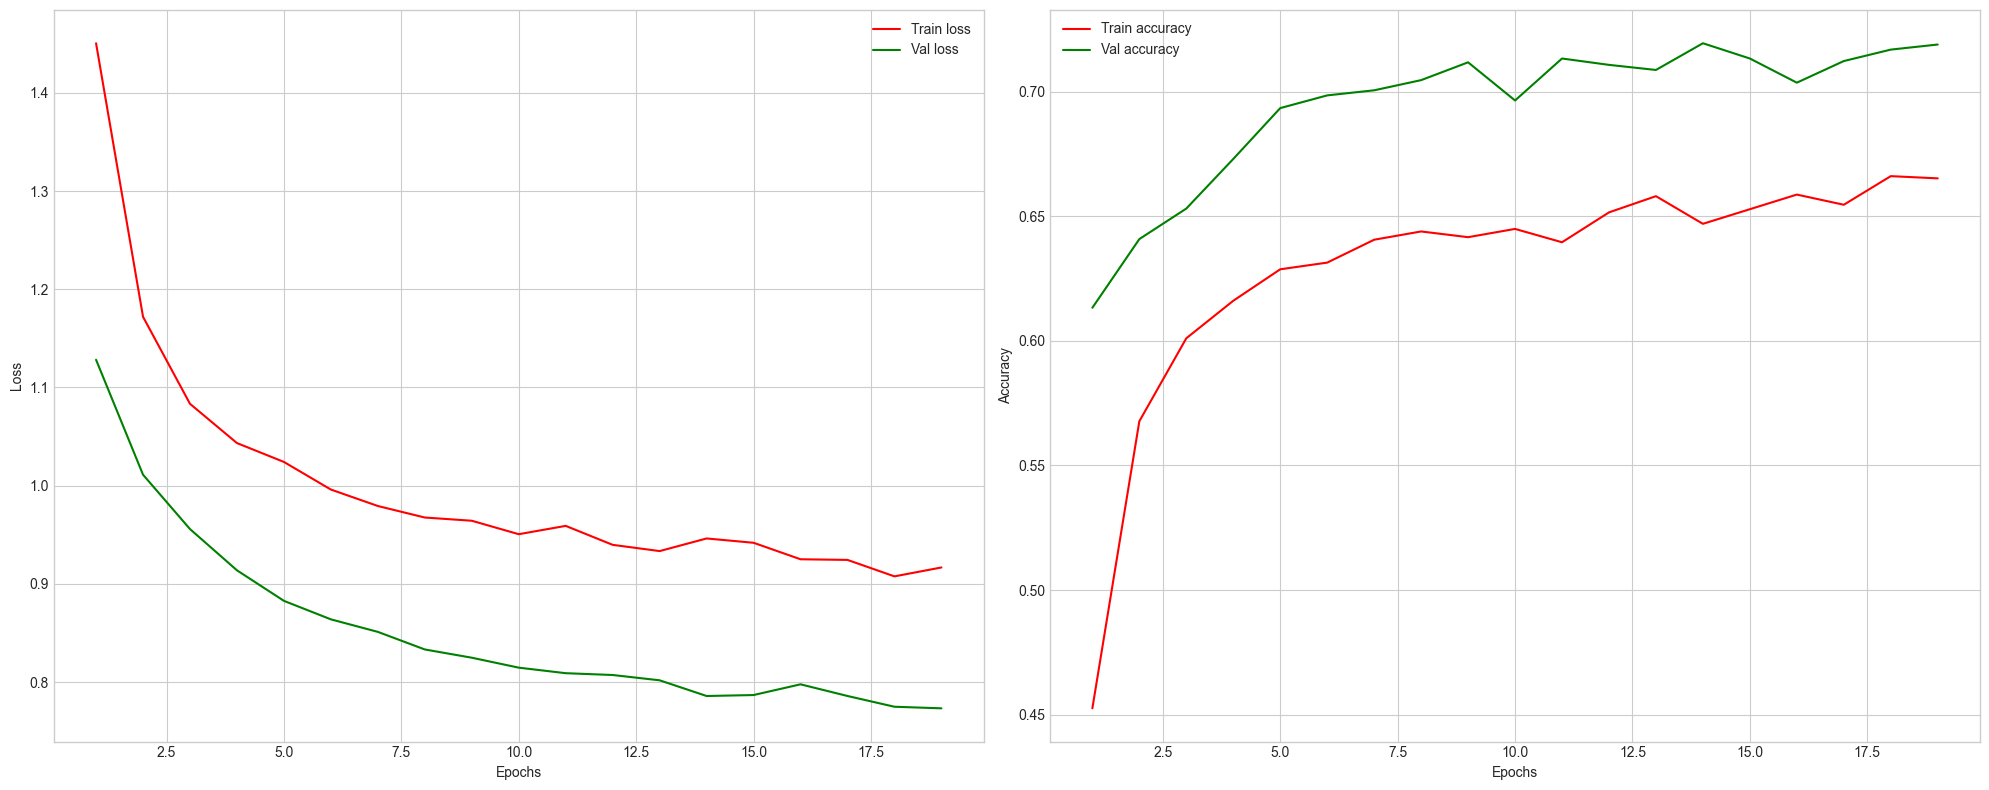

In [ ]:
efficientnet_model = train_model("EfficientNet-balanced", models_folder, efficientnet_model, efficientnet_x_train, efficientnet_y_train, efficientnet_x_val, efficientnet_y_val, batch_size, epochs)

62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - loss: 0.7857 - sparse_categorical_accuracy: 0.7191
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.9596 - sparse_categorical_accuracy: 0.6685
Val loss: 0.7858635187149048, Val accuracy: 0.7193877696990967
Test loss: 0.92891925573349, Test accuracy: 0.6726190447807312
48/48 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step


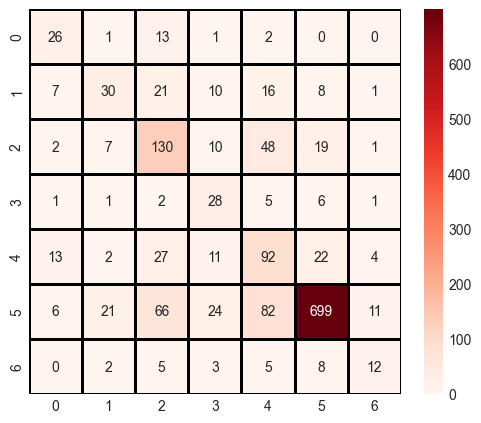

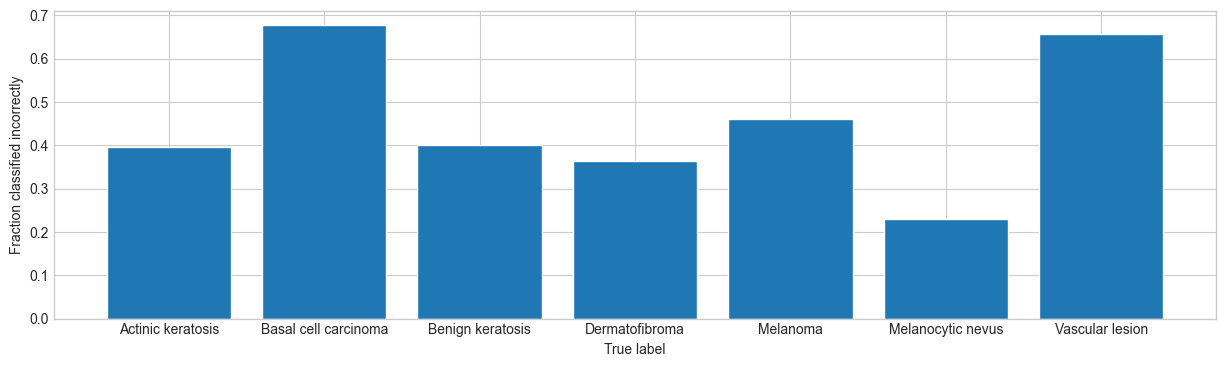

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.47      0.60      0.53        43
Basal cell carcinoma       0.47      0.32      0.38        93
    Benign keratosis       0.49      0.60      0.54       217
      Dermatofibroma       0.32      0.64      0.43        44
            Melanoma       0.37      0.54      0.44       171
   Melanocytic nevus       0.92      0.77      0.84       909
     Vascular lesion       0.40      0.34      0.37        35

            accuracy                           0.67      1512
           macro avg       0.49      0.54      0.50      1512
        weighted avg       0.72      0.67      0.69      1512



In [ ]:
evaluate_model(efficientnet_model, batch_size, efficientnet_x_val, efficientnet_y_val, efficientnet_x_test, efficientnet_y_test, categories, encodings)

## Fine tuning

### VGG16

In [ ]:
vgg16_model_ft = create_model("vgg16", vgg16_input_shape, classes=len(categories), trainable_encoder=True)

vgg16_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

vgg16_model_ft.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adjust_input (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 14,718,279 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.8162 - sparse_categorical_accuracy: 0.3446
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.63878, saving model to .\models\VGG16-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 6505s 7s/step - loss: 1.8158 - sparse_categorical_accuracy: 0.3447 - val_loss: 0.9926 - val_sparse_categorical_accuracy: 0.6388 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.9759 - sparse_categorical_accuracy: 0.6278
Epoch 2: val_sparse_categorical_accuracy improved from 0.63878 to 0.70714, saving model to .\models\VGG16-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 6400s 7s/step - loss: 0.9759 - sparse_categorical_accuracy: 0.6279 - val_loss: 0.7647 - val_sparse_categorical_accuracy: 0.7071 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.7086 - sparse_categorical_accuracy: 0.7283
Epoch 3: val_sparse_categorical_accuracy i

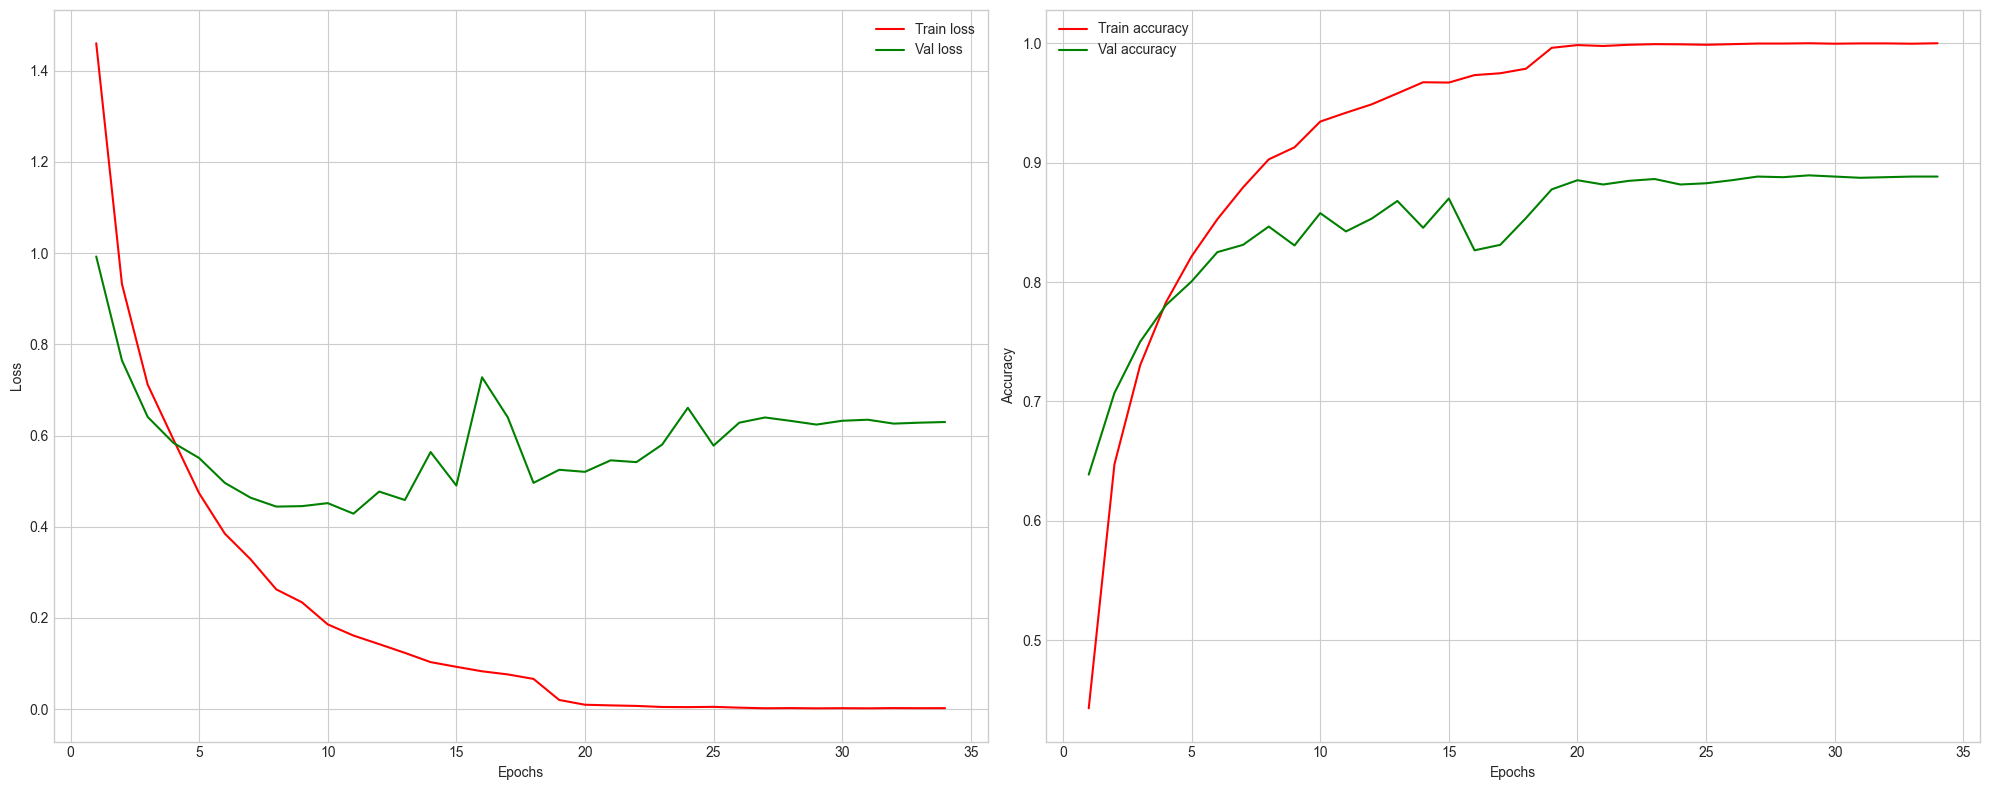

In [ ]:
vgg16_model_ft = train_model("VGG16-balanced-ft", models_folder, vgg16_model_ft, vgg16_x_train, vgg16_y_train, vgg16_x_val, vgg16_y_val, batch_size_ft, epochs)

245/245 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - loss: 0.6823 - sparse_categorical_accuracy: 0.8821
189/189 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - loss: 1.7291 - sparse_categorical_accuracy: 0.7460
Val loss: 0.6239761114120483, Val accuracy: 0.8892857432365417
Test loss: 1.7984468936920166, Test accuracy: 0.7414020895957947
189/189 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step


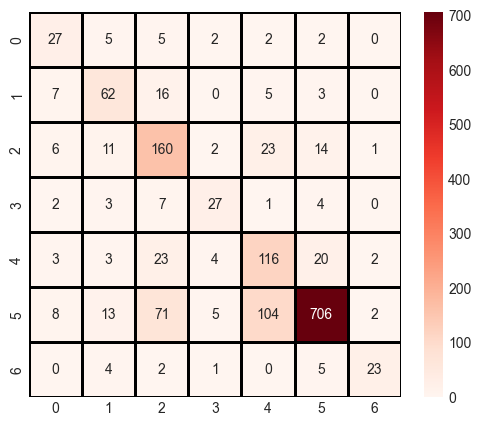

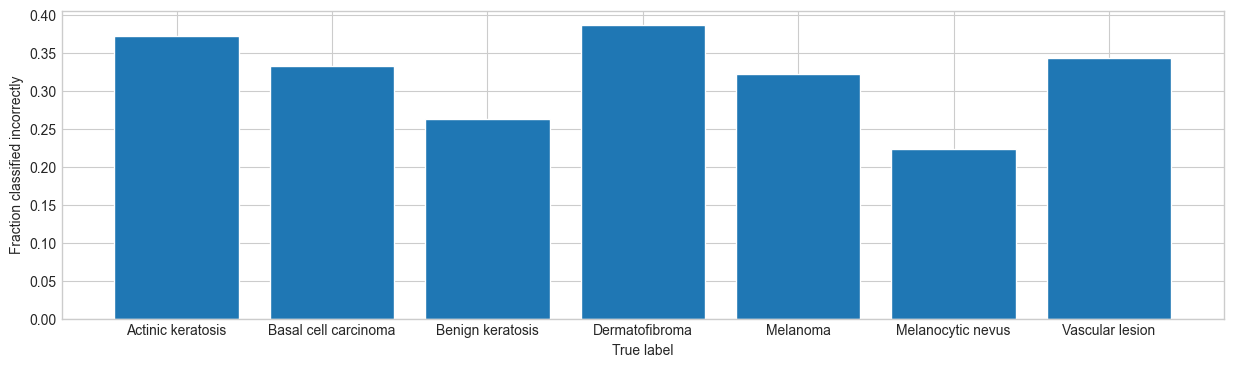

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.51      0.63      0.56        43
Basal cell carcinoma       0.61      0.67      0.64        93
    Benign keratosis       0.56      0.74      0.64       217
      Dermatofibroma       0.66      0.61      0.64        44
            Melanoma       0.46      0.68      0.55       171
   Melanocytic nevus       0.94      0.78      0.85       909
     Vascular lesion       0.82      0.66      0.73        35

            accuracy                           0.74      1512
           macro avg       0.65      0.68      0.66      1512
        weighted avg       0.79      0.74      0.75      1512



In [ ]:
evaluate_model(vgg16_model_ft, batch_size_ft, vgg16_x_val, vgg16_y_val, vgg16_x_test, vgg16_y_test, categories, encodings)

### InceptionV3

In [ ]:
inceptionv3_model_ft = create_model("inceptionv3", inceptionv3_input_shape, classes=len(categories), trainable_encoder=True)

inceptionv3_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
inceptionv3_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 299, 299,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 299, 299,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 149, 149,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 73, 73,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_192[0][0]

 Total params: 21,817,127 (83.23 MB)

 Trainable params: 21,782,695 (83.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.6956 - sparse_categorical_accuracy: 0.3379
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.68776, saving model to .\models\InceptionV3-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2954s 3s/step - loss: 1.6953 - sparse_categorical_accuracy: 0.3381 - val_loss: 0.8635 - val_sparse_categorical_accuracy: 0.6878 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.9629 - sparse_categorical_accuracy: 0.6389
Epoch 2: val_sparse_categorical_accuracy improved from 0.68776 to 0.77602, saving model to .\models\InceptionV3-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 3046s 3s/step - loss: 0.9628 - sparse_categorical_accuracy: 0.6389 - val_loss: 0.6247 - val_sparse_categorical_accuracy: 0.7760 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7379
Epoch 3: val_sparse_categorica

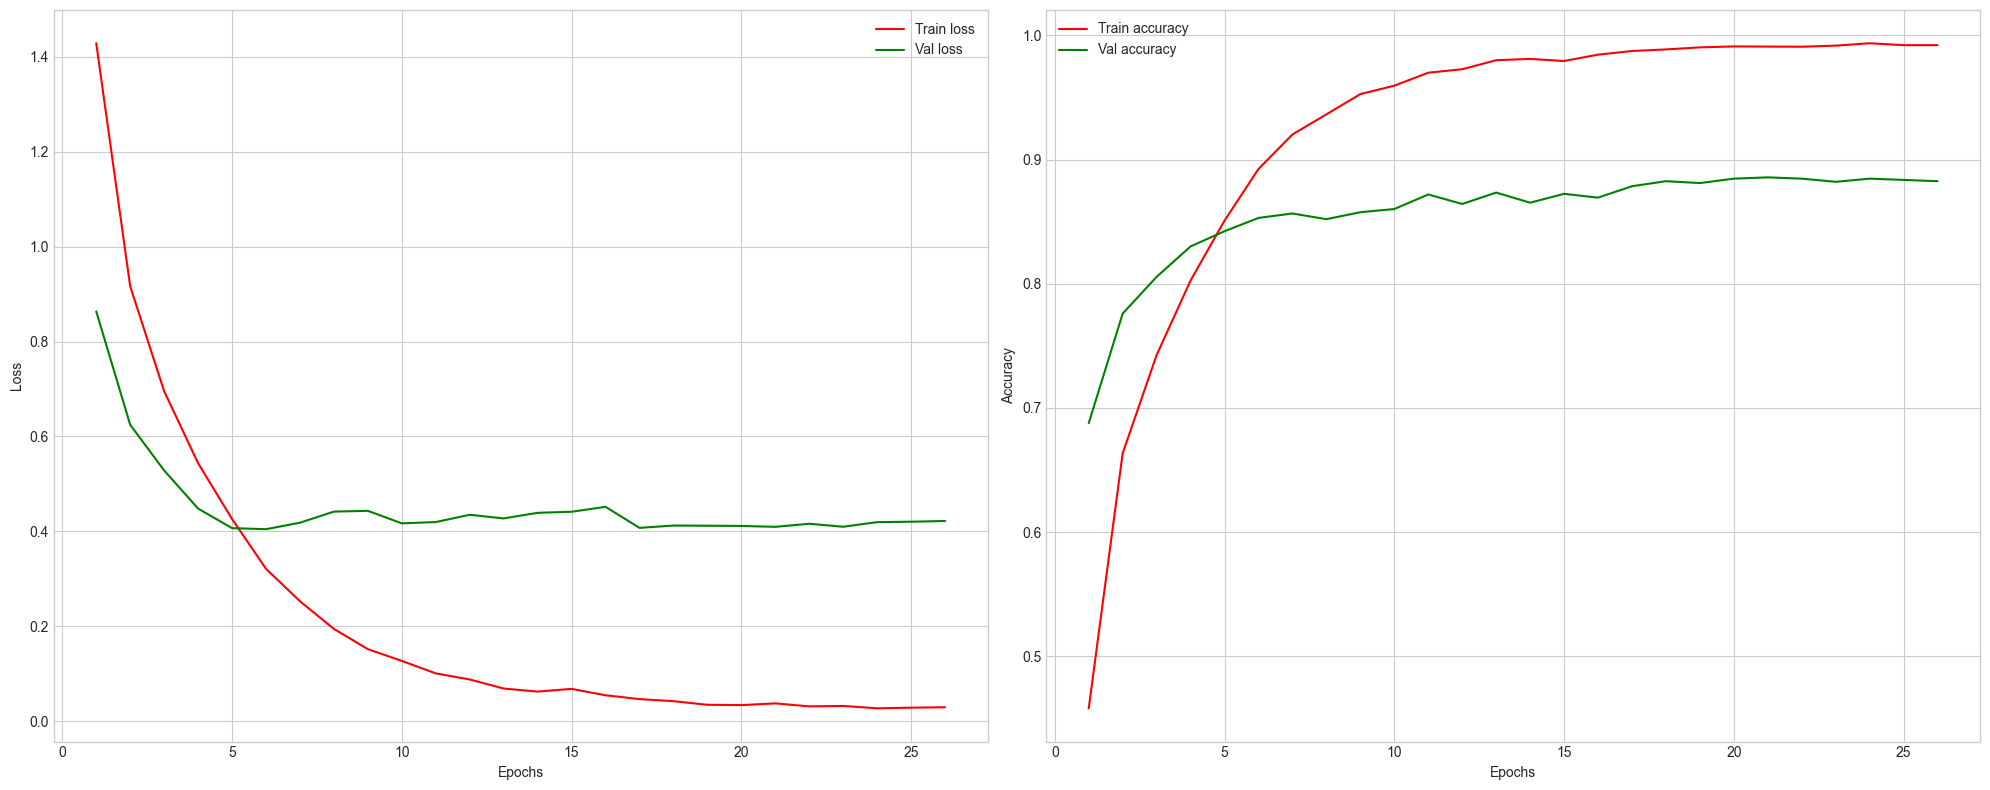

In [ ]:
inceptionv3_model_ft = train_model("InceptionV3-balanced-ft", models_folder, inceptionv3_model_ft, inceptionv3_x_train, inceptionv3_y_train, inceptionv3_x_val, inceptionv3_y_val, batch_size_ft, epochs)

245/245 ━━━━━━━━━━━━━━━━━━━━ 156s 638ms/step - loss: 0.4062 - sparse_categorical_accuracy: 0.8884
189/189 ━━━━━━━━━━━━━━━━━━━━ 118s 626ms/step - loss: 0.8706 - sparse_categorical_accuracy: 0.7474
Val loss: 0.4097232222557068, Val accuracy: 0.8857142925262451
Test loss: 0.8873333930969238, Test accuracy: 0.7625661492347717
189/189 ━━━━━━━━━━━━━━━━━━━━ 132s 679ms/step


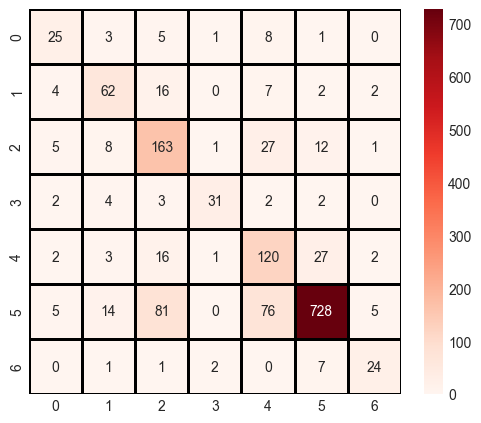

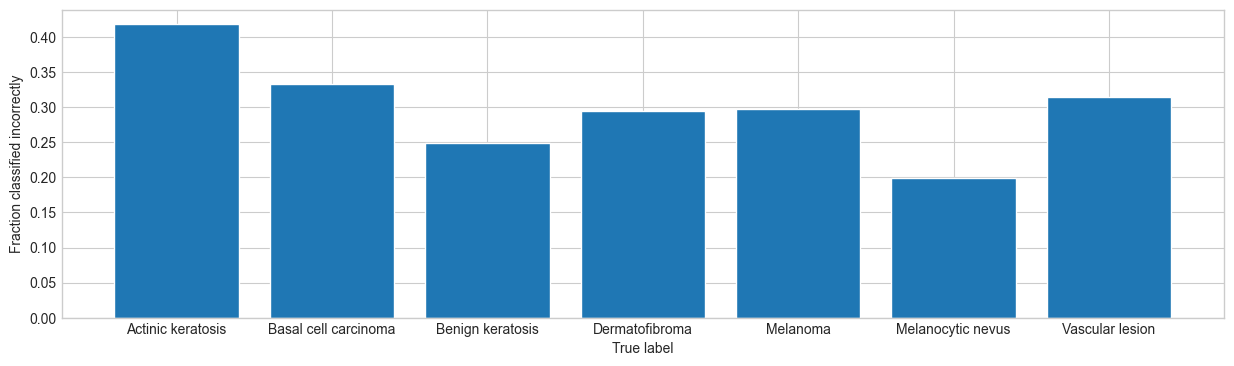

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.58      0.58      0.58        43
Basal cell carcinoma       0.65      0.67      0.66        93
    Benign keratosis       0.57      0.75      0.65       217
      Dermatofibroma       0.86      0.70      0.78        44
            Melanoma       0.50      0.70      0.58       171
   Melanocytic nevus       0.93      0.80      0.86       909
     Vascular lesion       0.71      0.69      0.70        35

            accuracy                           0.76      1512
           macro avg       0.69      0.70      0.69      1512
        weighted avg       0.80      0.76      0.77      1512



In [ ]:
evaluate_model(inceptionv3_model_ft, batch_size_ft, inceptionv3_x_val, inceptionv3_y_val, inceptionv3_x_test, inceptionv3_y_test, categories, encodings)

### ResNet

In [ ]:
resnet_model_ft = create_model("resnet", resnet_input_shape, classes=len(categories), trainable_encoder=True)

resnet_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

resnet_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ adjust_input[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 23,533,703 (89.77 MB)

 Non-trainable params: 45,440 (177.50 KB)

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8800 - sparse_categorical_accuracy: 0.2831
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.64133, saving model to .\models\ResNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2084s 2s/step - loss: 1.8797 - sparse_categorical_accuracy: 0.2832 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.6413 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0749 - sparse_categorical_accuracy: 0.6014
Epoch 2: val_sparse_categorical_accuracy improved from 0.64133 to 0.70969, saving model to .\models\ResNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2072s 2s/step - loss: 1.0749 - sparse_categorical_accuracy: 0.6015 - val_loss: 0.7562 - val_sparse_categorical_accuracy: 0.7097 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8201 - sparse_categorical_accuracy: 0.7058
Epoch 3: val_sparse_categorical_accuracy

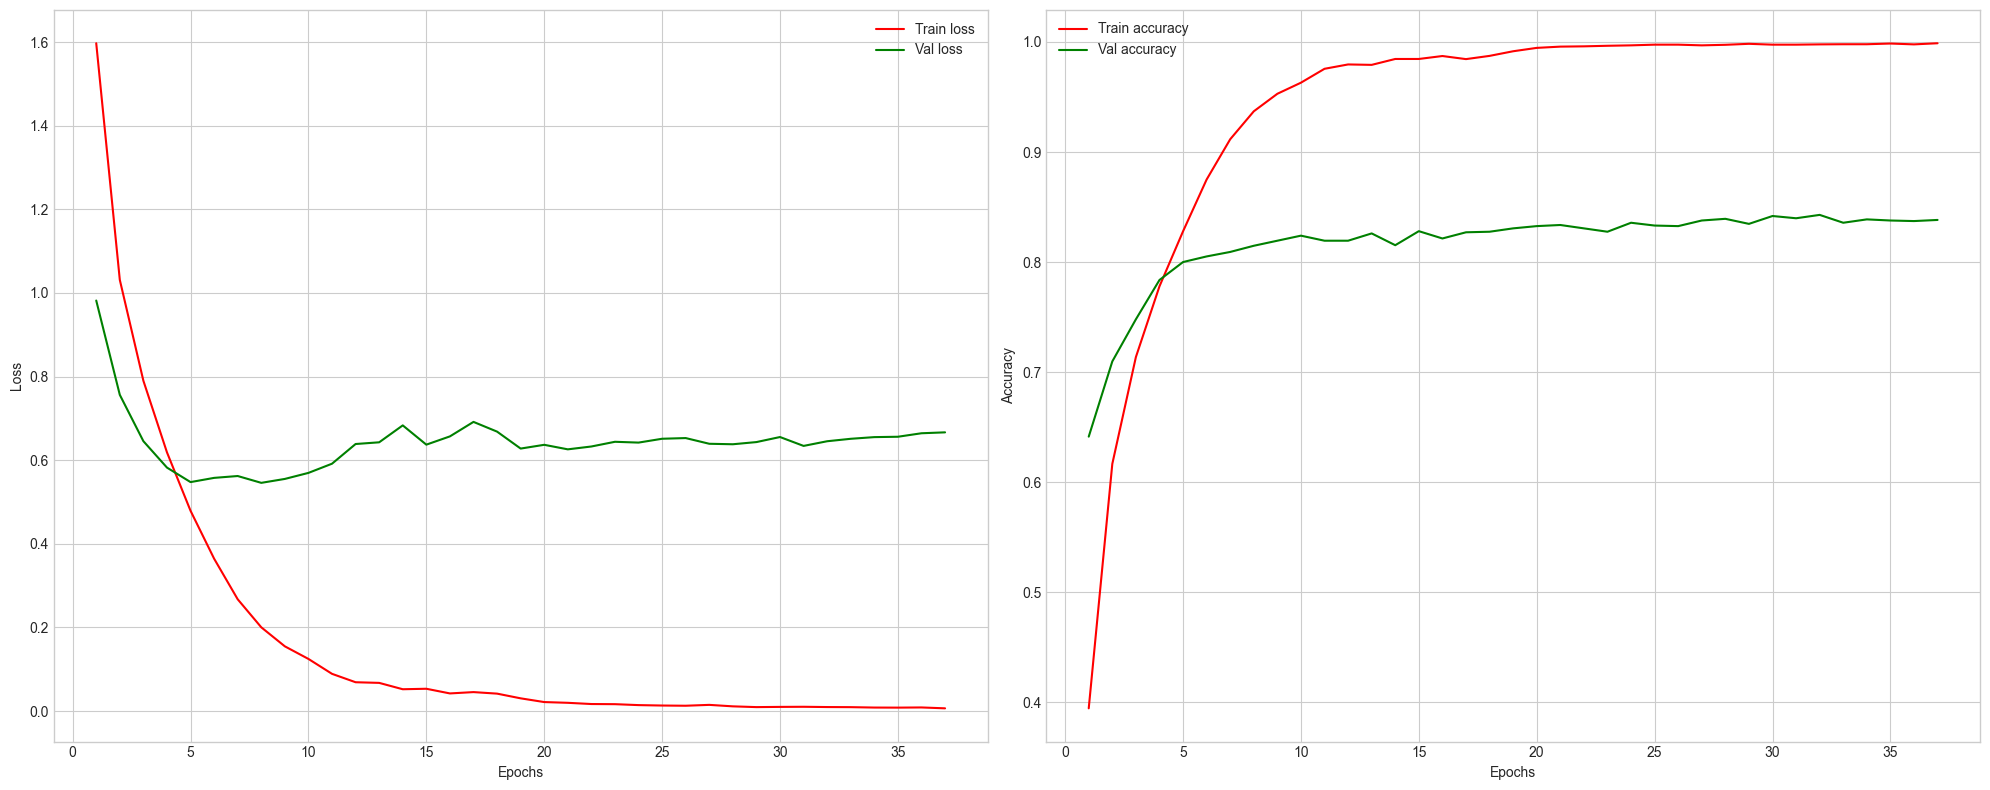

In [ ]:
resnet_model_ft = train_model("ResNet-balanced-ft", models_folder, resnet_model_ft, resnet_x_train, resnet_y_train, resnet_x_val, resnet_y_val, batch_size_ft, epochs)

245/245 ━━━━━━━━━━━━━━━━━━━━ 126s 512ms/step - loss: 0.6973 - sparse_categorical_accuracy: 0.8333
189/189 ━━━━━━━━━━━━━━━━━━━━ 98s 520ms/step - loss: 1.3775 - sparse_categorical_accuracy: 0.6827
Val loss: 0.6451982259750366, Val accuracy: 0.8428571224212646
Test loss: 1.3552051782608032, Test accuracy: 0.6937830448150635
189/189 ━━━━━━━━━━━━━━━━━━━━ 96s 485ms/step


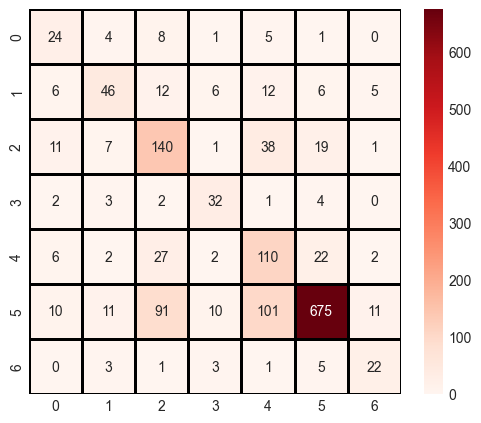

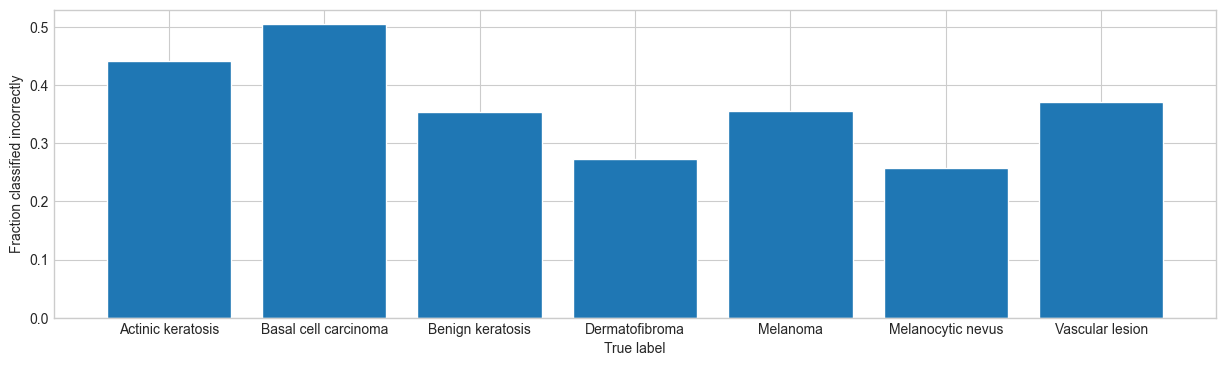

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.41      0.56      0.47        43
Basal cell carcinoma       0.61      0.49      0.54        93
    Benign keratosis       0.50      0.65      0.56       217
      Dermatofibroma       0.58      0.73      0.65        44
            Melanoma       0.41      0.64      0.50       171
   Melanocytic nevus       0.92      0.74      0.82       909
     Vascular lesion       0.54      0.63      0.58        35

            accuracy                           0.69      1512
           macro avg       0.57      0.63      0.59      1512
        weighted avg       0.75      0.69      0.71      1512



In [ ]:
evaluate_model(resnet_model_ft, batch_size_ft, resnet_x_val, resnet_y_val, resnet_x_test, resnet_y_test, categories, encodings)

### MobileNet

In [ ]:
mobilenet_model_ft = create_model("mobilenet", mobilenet_input_shape, classes=len(categories), trainable_encoder=True)

mobilenet_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

mobilenet_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,232,839 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - loss: 1.9177 - sparse_categorical_accuracy: 0.2829
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.44490, saving model to .\models\MobileNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 672s 658ms/step - loss: 1.9175 - sparse_categorical_accuracy: 0.2830 - val_loss: 1.5457 - val_sparse_categorical_accuracy: 0.4449 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 1.2335 - sparse_categorical_accuracy: 0.5453
Epoch 2: val_sparse_categorical_accuracy improved from 0.44490 to 0.63673, saving model to .\models\MobileNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 604s 616ms/step - loss: 1.2335 - sparse_categorical_accuracy: 0.5453 - val_loss: 0.9980 - val_sparse_categorical_accuracy: 0.6367 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - loss: 1.0516 - sparse_categorical_accuracy: 0.6079
Epoch 3: val_sparse_c

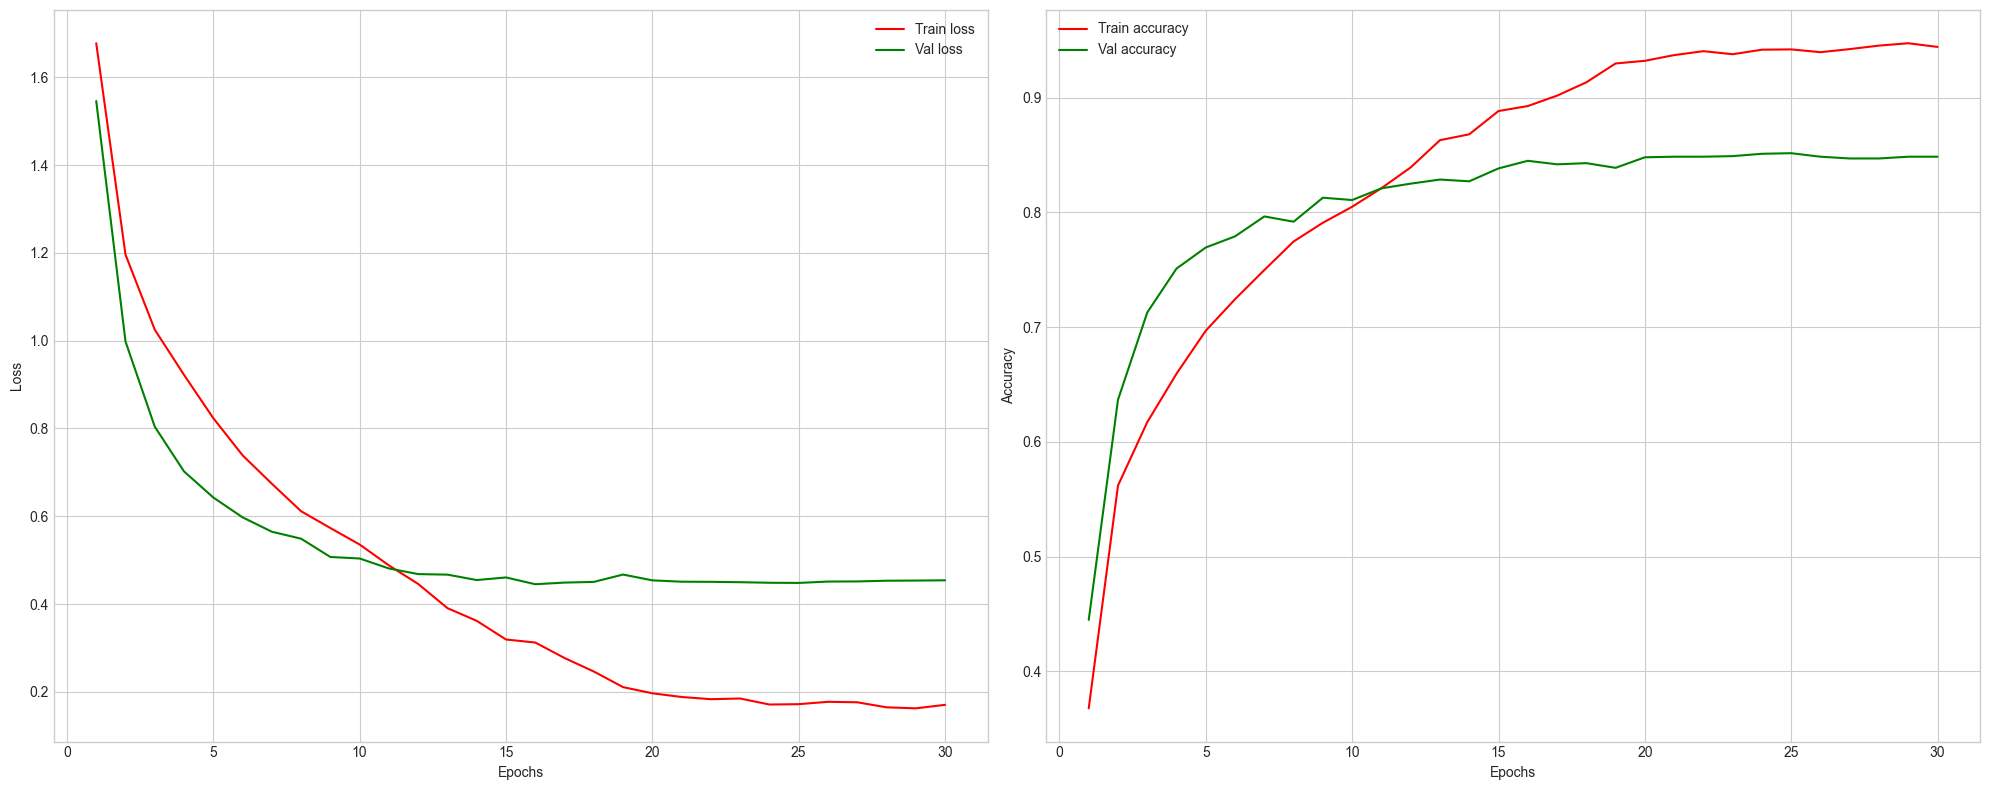

In [ ]:
mobilenet_model_ft = train_model("MobileNet-balanced-ft", models_folder, mobilenet_model_ft, mobilenet_x_train, mobilenet_y_train, mobilenet_x_val, mobilenet_y_val, batch_size_ft, epochs)

245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - loss: 0.4357 - sparse_categorical_accuracy: 0.8619
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - loss: 0.8843 - sparse_categorical_accuracy: 0.7264
Val loss: 0.4481664001941681, Val accuracy: 0.8515306115150452
Test loss: 0.8600854873657227, Test accuracy: 0.7328042387962341
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step


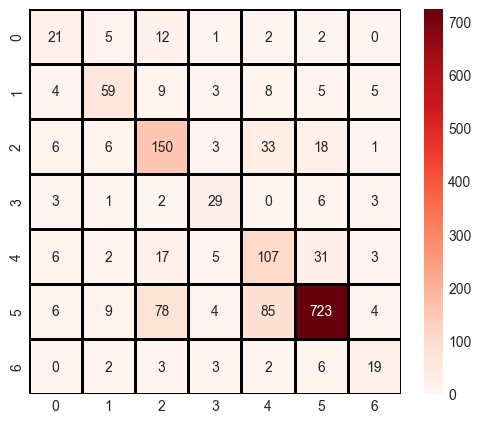

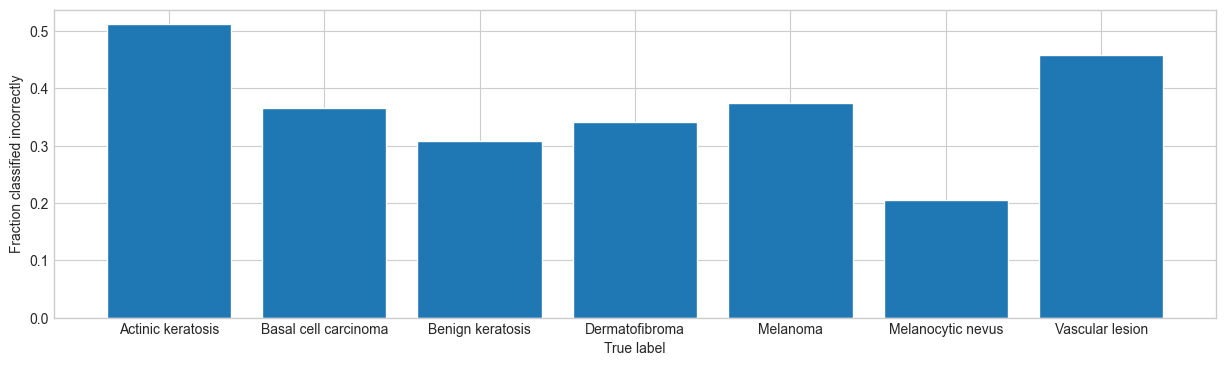

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.46      0.49      0.47        43
Basal cell carcinoma       0.70      0.63      0.67        93
    Benign keratosis       0.55      0.69      0.61       217
      Dermatofibroma       0.60      0.66      0.63        44
            Melanoma       0.45      0.63      0.52       171
   Melanocytic nevus       0.91      0.80      0.85       909
     Vascular lesion       0.54      0.54      0.54        35

            accuracy                           0.73      1512
           macro avg       0.60      0.63      0.61      1512
        weighted avg       0.77      0.73      0.74      1512



In [ ]:
evaluate_model(mobilenet_model_ft, batch_size_ft, mobilenet_x_val, mobilenet_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)

### EfficientNet

In [13]:
efficientnet_model_ft = create_model("efficientnet", efficientnet_input_shape, classes=len(categories), trainable_encoder=True)

efficientnet_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

efficientnet_model_ft.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 260, 260,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 260, 260,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ adjust_input[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati

 Total params: 7,778,432 (29.67 MB)

 Trainable params: 7,710,857 (29.41 MB)

 Non-trainable params: 67,575 (263.97 KB)

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8064 - sparse_categorical_accuracy: 0.2816
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.61582, saving model to .\models\EfficientNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2192s 2s/step - loss: 1.8062 - sparse_categorical_accuracy: 0.2817 - val_loss: 1.2061 - val_sparse_categorical_accuracy: 0.6158 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2327 - sparse_categorical_accuracy: 0.5647
Epoch 2: val_sparse_categorical_accuracy improved from 0.61582 to 0.70459, saving model to .\models\EfficientNet-balanced-ft\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2172s 2s/step - loss: 1.2326 - sparse_categorical_accuracy: 0.5647 - val_loss: 0.8446 - val_sparse_categorical_accuracy: 0.7046 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.9711 - sparse_categorical_accuracy: 0.6464
Epoch 3: val_sparse_categori

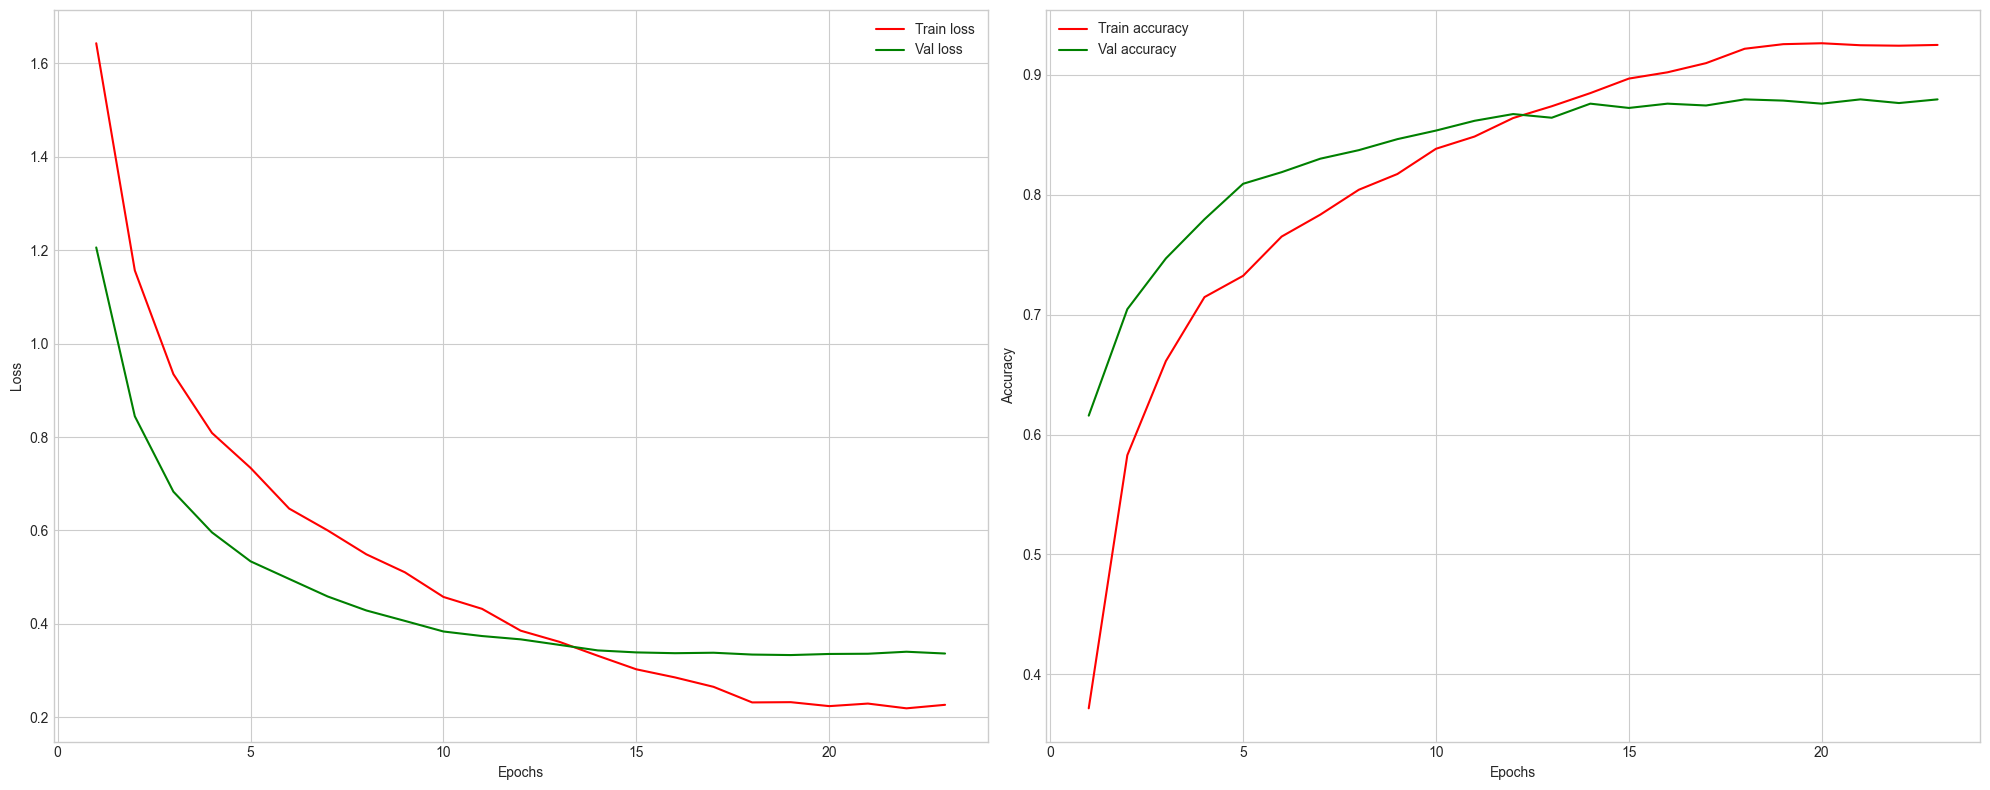

In [ ]:
efficientnet_model_ft = train_model("EfficientNet-balanced-ft", models_folder, efficientnet_model_ft, efficientnet_x_train, efficientnet_y_train, efficientnet_x_val, efficientnet_y_val, batch_size_ft, epochs)

245/245 ━━━━━━━━━━━━━━━━━━━━ 92s 375ms/step - loss: 0.3382 - sparse_categorical_accuracy: 0.8798
189/189 ━━━━━━━━━━━━━━━━━━━━ 68s 358ms/step - loss: 0.6419 - sparse_categorical_accuracy: 0.7831
Val loss: 0.33433088660240173, Val accuracy: 0.8795918226242065
Test loss: 0.6497999429702759, Test accuracy: 0.7784391641616821
189/189 ━━━━━━━━━━━━━━━━━━━━ 71s 378ms/step


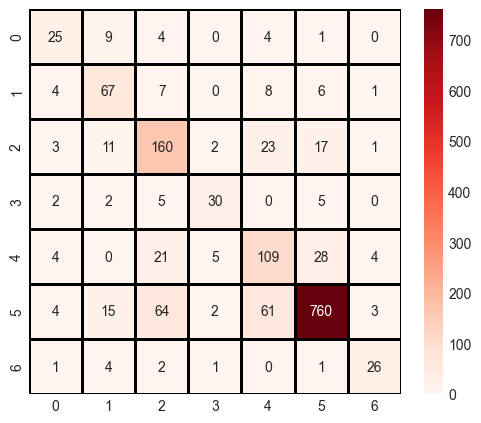

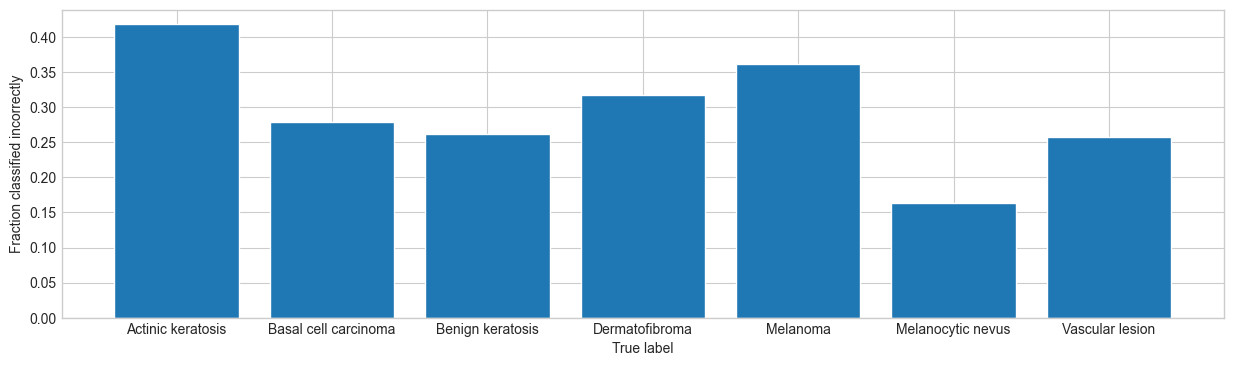

Classification Report:
                      precision    recall  f1-score   support

   Actinic keratosis       0.58      0.58      0.58        43
Basal cell carcinoma       0.62      0.72      0.67        93
    Benign keratosis       0.61      0.74      0.67       217
      Dermatofibroma       0.75      0.68      0.71        44
            Melanoma       0.53      0.64      0.58       171
   Melanocytic nevus       0.93      0.84      0.88       909
     Vascular lesion       0.74      0.74      0.74        35

            accuracy                           0.78      1512
           macro avg       0.68      0.71      0.69      1512
        weighted avg       0.80      0.78      0.79      1512



In [ ]:
evaluate_model(efficientnet_model_ft, batch_size_ft, efficientnet_x_val, efficientnet_y_val, efficientnet_x_test, efficientnet_y_test, categories, encodings)

## Urgent vs Non-urgent  

In [13]:
label_mapping

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [14]:
df['dx'] = df['dx'].replace('bcc', 'urgent')
df['dx'] = df['dx'].replace('mel', 'urgent')
df['dx'] = df['dx'].replace('akiec', 'urgent')
df['dx'] = df['dx'].replace('bkl', 'non-urgent')
df['dx'] = df['dx'].replace('df', 'non-urgent')
df['dx'] = df['dx'].replace('nv', 'non-urgent')
df['dx'] = df['dx'].replace('vasc', 'non-urgent')

In [15]:
label_encoder_bin = LabelEncoder()
label_encoder_bin.fit(df['dx'])

categories_bin = list(label_encoder_bin.classes_)
encodings_bin = label_encoder_bin.transform(label_encoder_bin.classes_)

label_mapping_bin = dict(zip(categories_bin, encodings_bin))
label_mapping_bin

{'non-urgent': 0, 'urgent': 1}

In [16]:
def update_y(y, label_mapping, label_mapping_bin):
    for i in range(len(y)):
        if y[i] in [label_mapping["bcc"], label_mapping["mel"], label_mapping["akiec"]]:
            y[i] = label_mapping_bin["urgent"]
        else:
            y[i] = label_mapping_bin["non-urgent"]
    return y

In [17]:
efficientnet_y_test_bin = update_y(efficientnet_y_test, label_mapping, label_mapping_bin)
efficientnet_y_train_bin = update_y(efficientnet_y_train, label_mapping, label_mapping_bin)
efficientnet_y_val_bin = update_y(efficientnet_y_val, label_mapping, label_mapping_bin)

In [18]:
total_samples = len(efficientnet_y_train_bin)
urgent_samples = np.sum(efficientnet_y_train_bin)
non_urgent_samples = total_samples - urgent_samples

In [19]:
class_weights = {
    0: 1,
    1: 2
}

class_weights

{0: 1, 1: 2}

In [20]:
efficientnet_model_ft_bin = create_model("efficientnet", efficientnet_input_shape, classes=len(categories_bin), trainable_encoder=True)

efficientnet_model_ft_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

Epoch 1/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8811 - sparse_categorical_accuracy: 0.6173
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.75714, saving model to .\models\EfficientNet-balanced-ft-binary\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2221s 2s/step - loss: 0.8811 - sparse_categorical_accuracy: 0.6173 - val_loss: 0.4917 - val_sparse_categorical_accuracy: 0.7571 - learning_rate: 1.0000e-05
Epoch 2/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6991 - sparse_categorical_accuracy: 0.7253
Epoch 2: val_sparse_categorical_accuracy improved from 0.75714 to 0.77857, saving model to .\models\EfficientNet-balanced-ft-binary\trained_model.keras
980/980 ━━━━━━━━━━━━━━━━━━━━ 2120s 2s/step - loss: 0.6991 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.4393 - val_sparse_categorical_accuracy: 0.7786 - learning_rate: 1.0000e-05
Epoch 3/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6222 - sparse_categorical_accuracy: 0.7599
Epoch 3: val_s

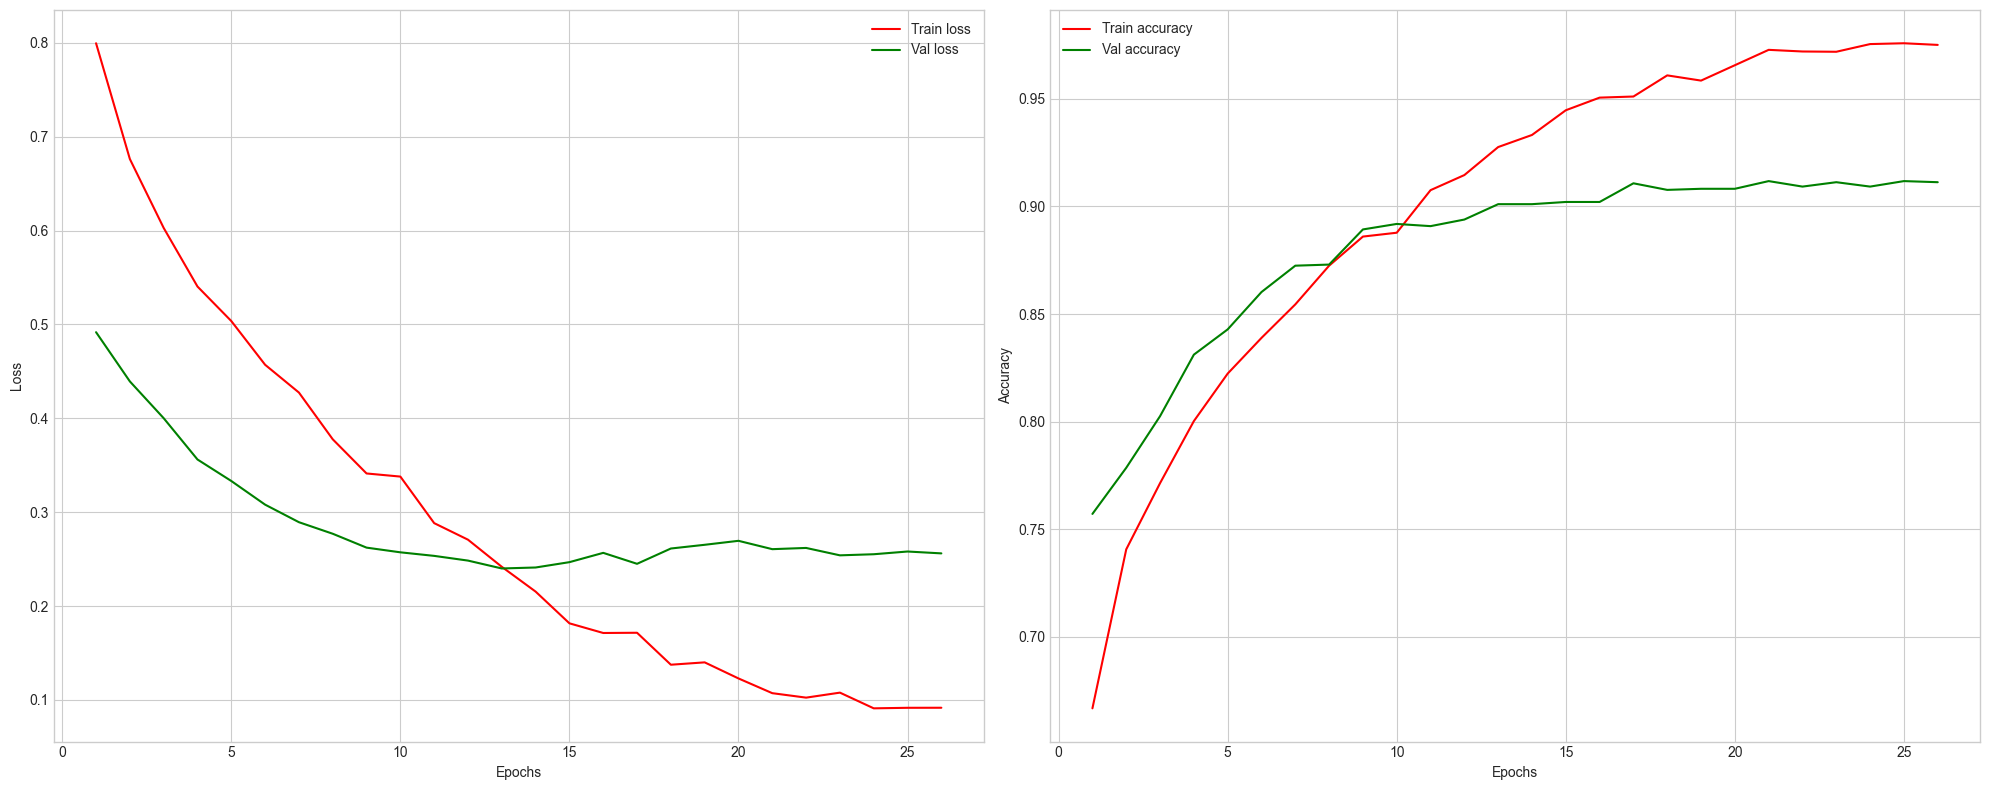

In [ ]:
efficientnet_model_ft_bin = train_model("EfficientNet-balanced-ft-binary", models_folder, efficientnet_model_ft_bin, efficientnet_x_train, efficientnet_y_train_bin, efficientnet_x_val, efficientnet_y_val_bin, batch_size_ft, epochs, class_weights=class_weights)

245/245 ━━━━━━━━━━━━━━━━━━━━ 91s 372ms/step - loss: 0.2839 - sparse_categorical_accuracy: 0.8983
189/189 ━━━━━━━━━━━━━━━━━━━━ 73s 386ms/step - loss: 0.4874 - sparse_categorical_accuracy: 0.8277
Val loss: 0.2605884373188019, Val accuracy: 0.9117347002029419
Test loss: 0.4851364493370056, Test accuracy: 0.8280423283576965
189/189 ━━━━━━━━━━━━━━━━━━━━ 72s 356ms/step


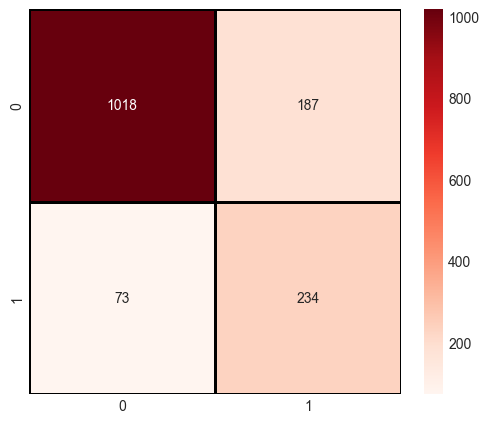

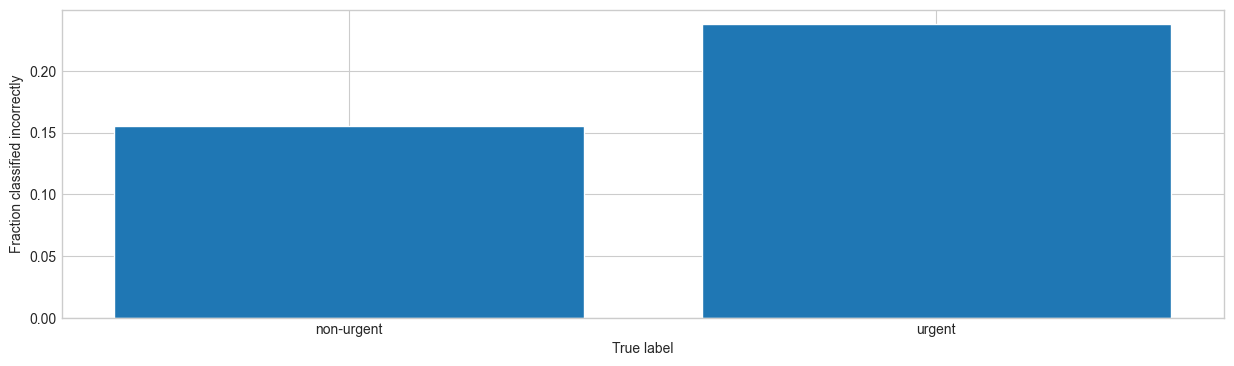

Classification Report:
              precision    recall  f1-score   support

  non-urgent       0.93      0.84      0.89      1205
      urgent       0.56      0.76      0.64       307

    accuracy                           0.83      1512
   macro avg       0.74      0.80      0.76      1512
weighted avg       0.86      0.83      0.84      1512



In [22]:
evaluate_model(efficientnet_model_ft_bin, batch_size_ft, efficientnet_x_val, efficientnet_y_val_bin, efficientnet_x_test, efficientnet_y_test_bin, categories_bin, encodings_bin)